In [1]:
import sys
import itertools

import matplotlib.pyplot as plt

sys.path.append('..')
from antlia import lidar

%load_ext autoreload
%autoreload 2

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [2]:
def set_title(ax, title):
    try:
        mpld3
    except NameError:
        ax.figure.suptitle(title)
    else:
        ax.set_title(title)
        
DEFAULT_FIGSIZE = (14, 7)

In [3]:
records = lidar.load_records(sync=False)

Unable to determine range 2
Unable to determine range 1


/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


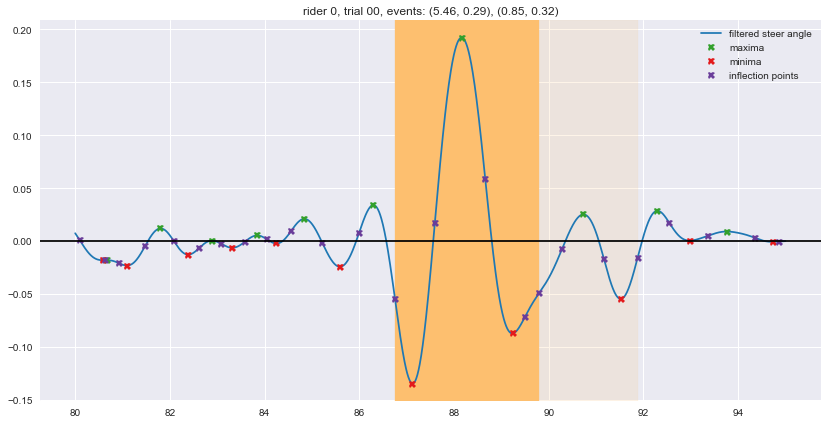

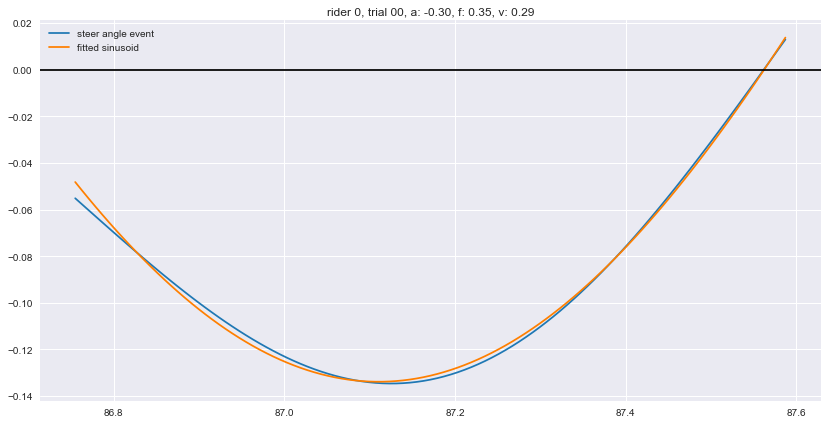

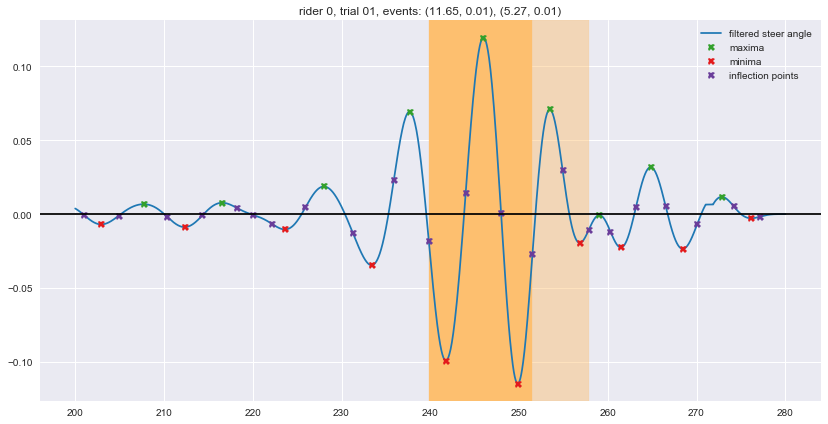

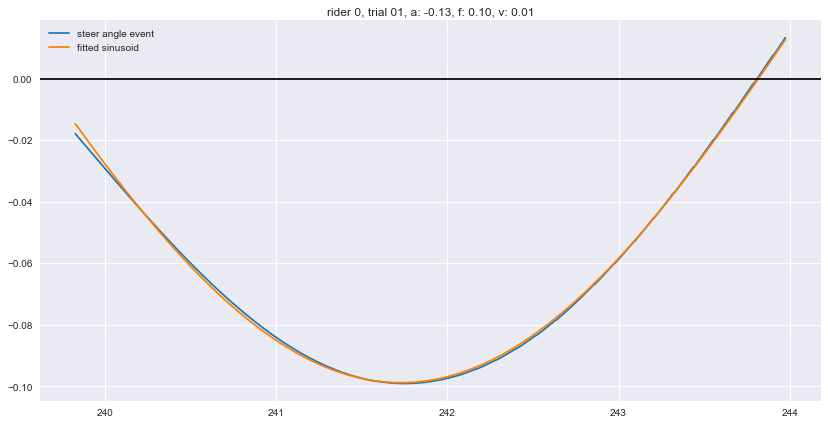

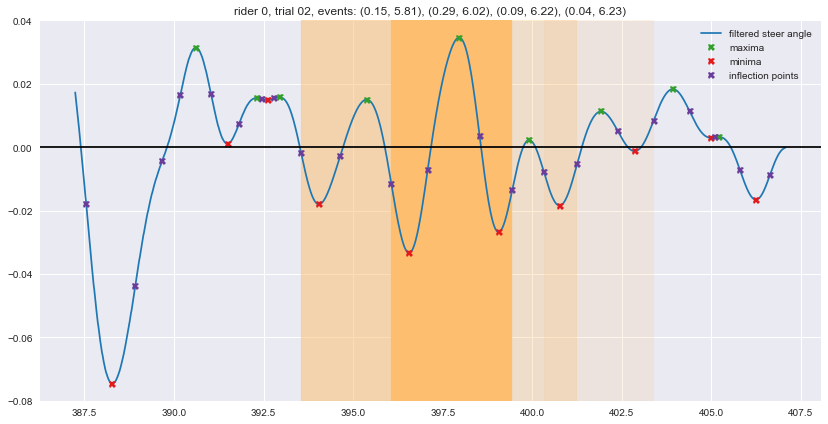

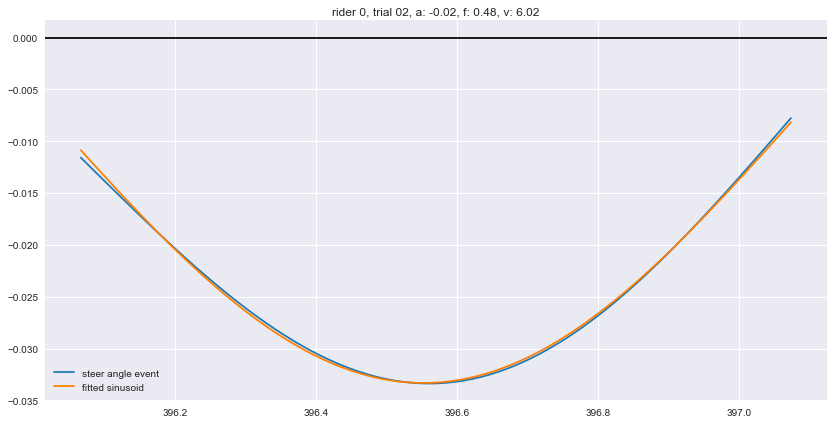

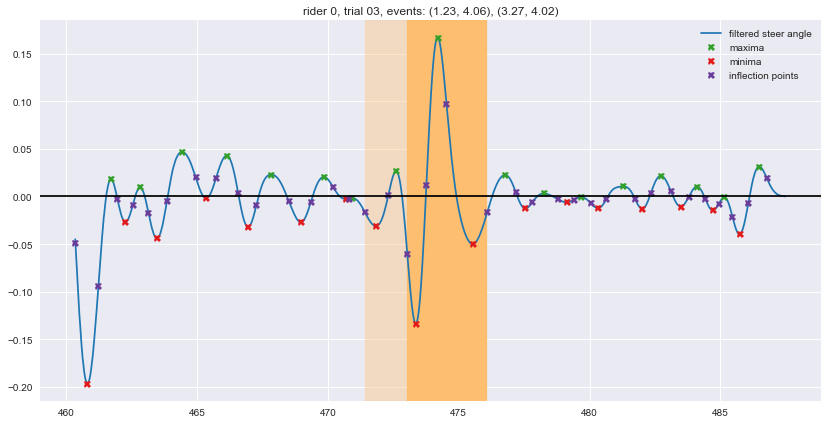

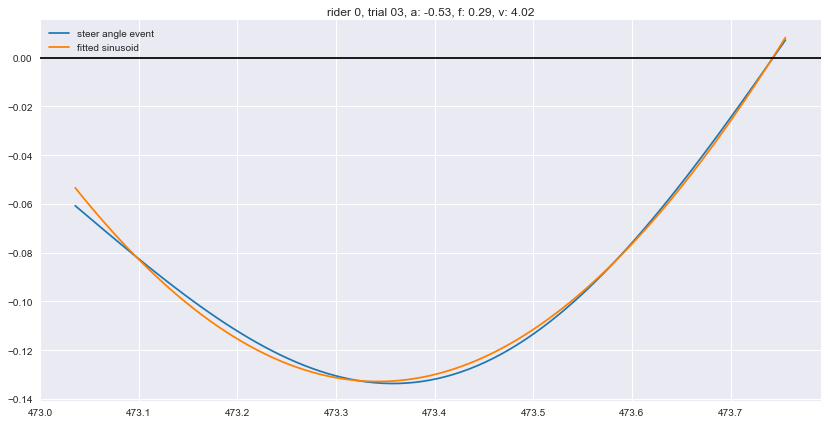

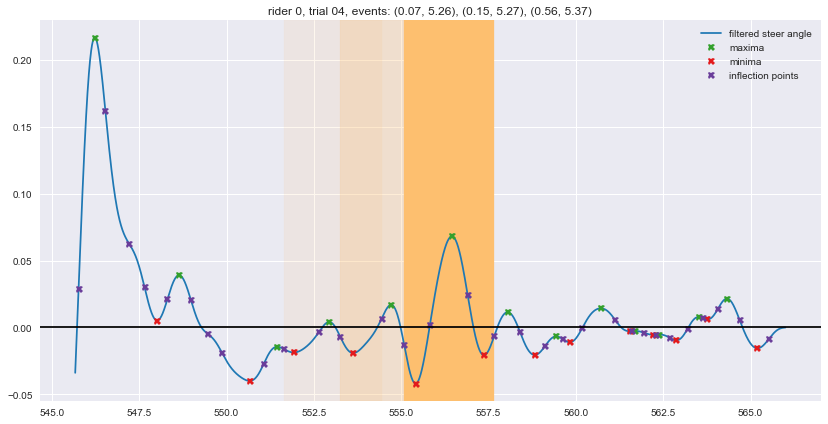

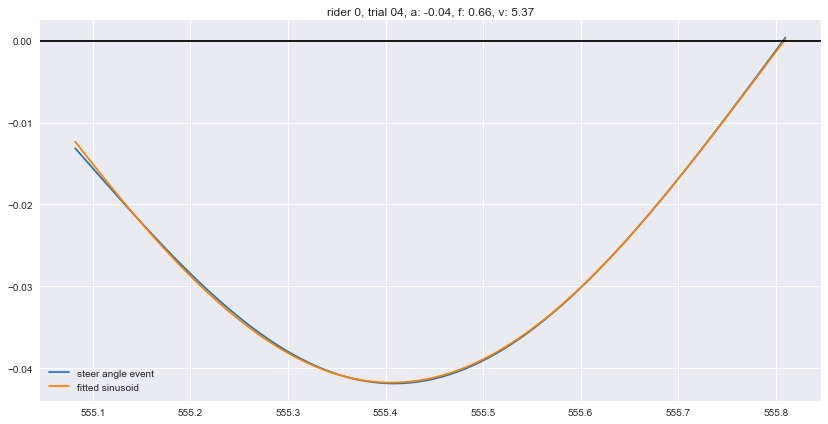

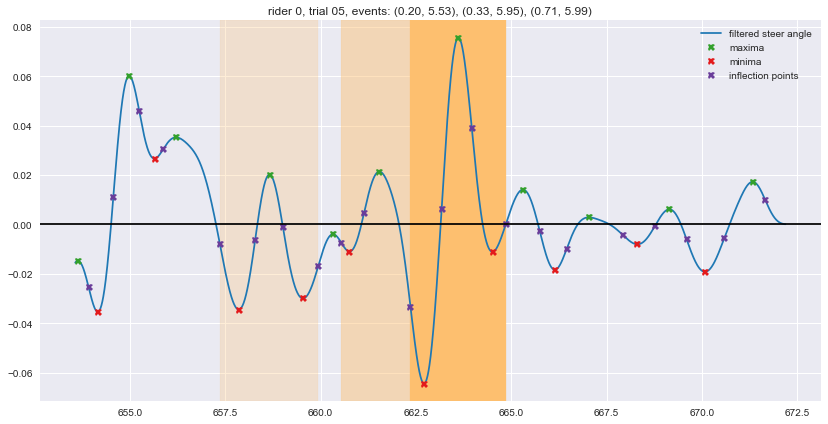

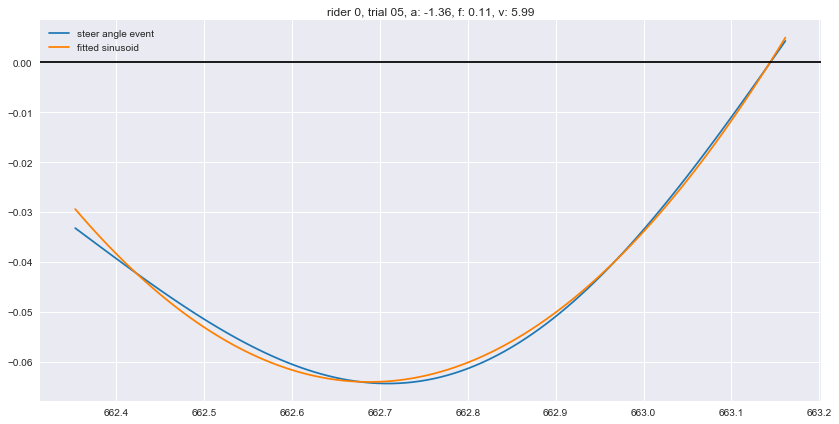

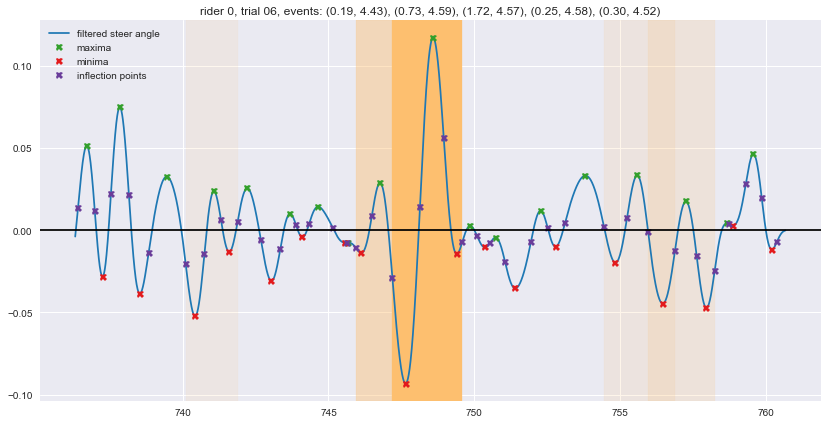

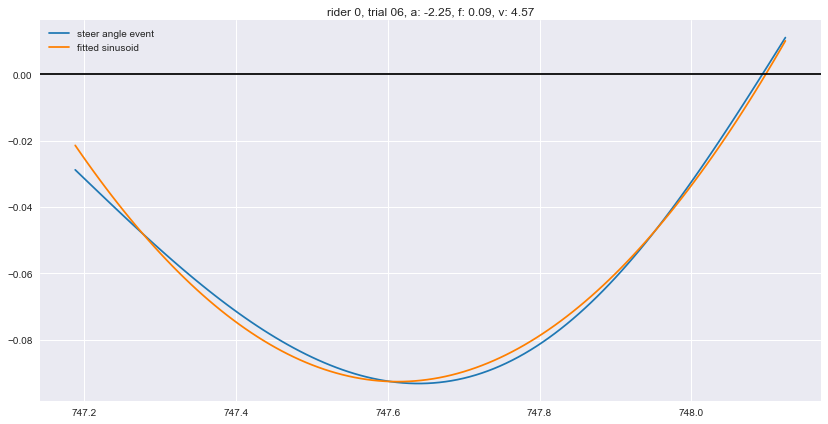

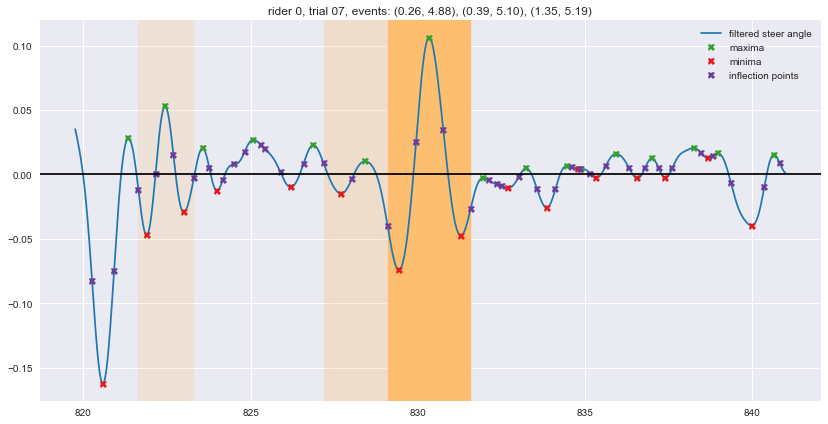

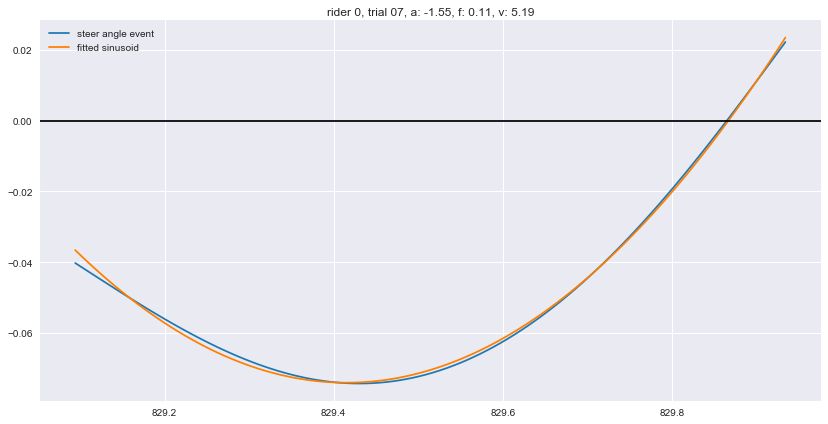

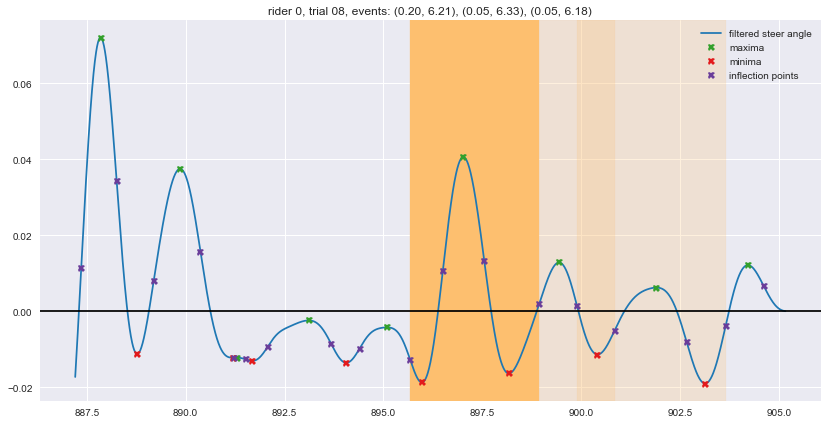

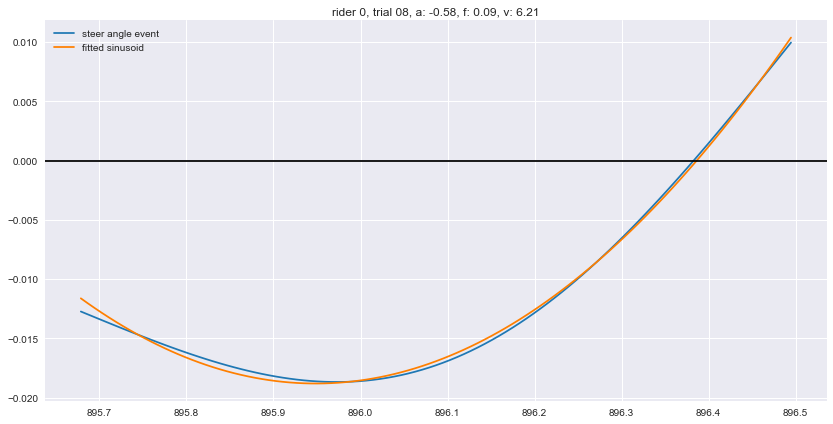

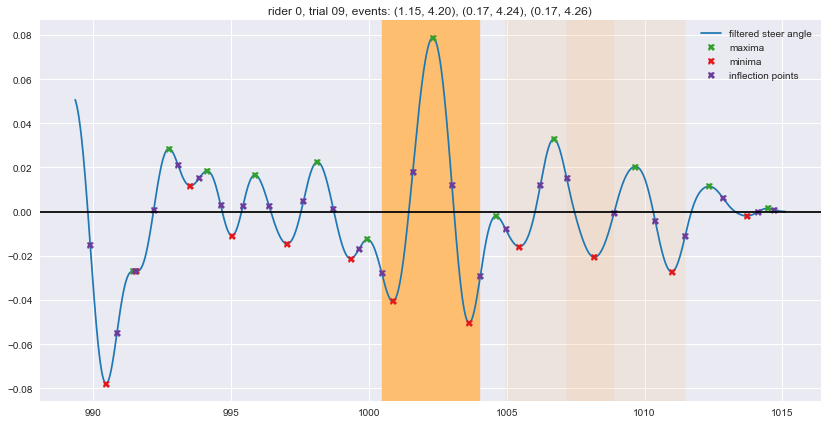

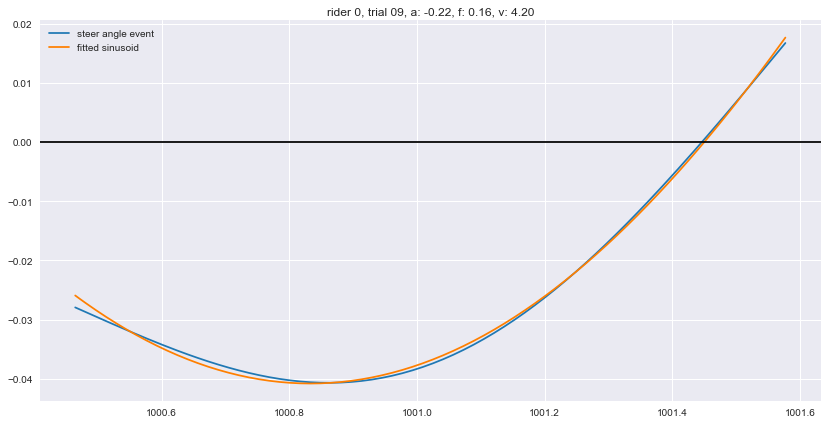

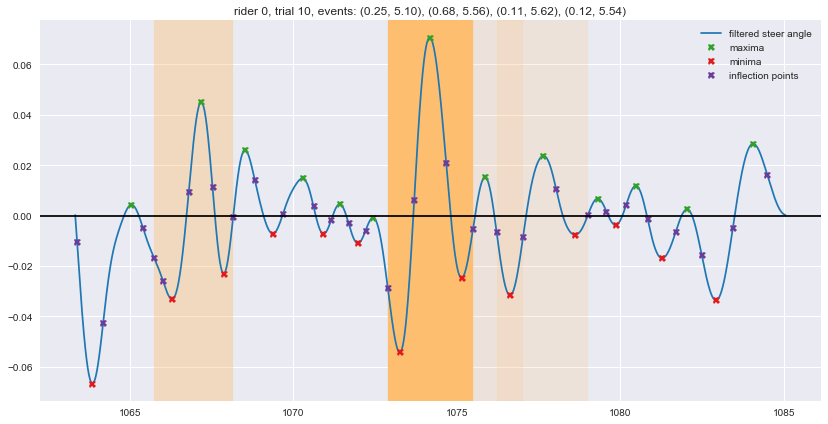

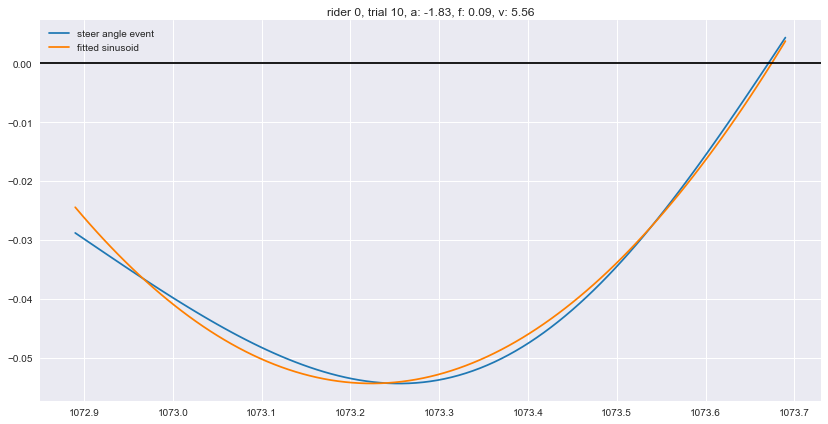

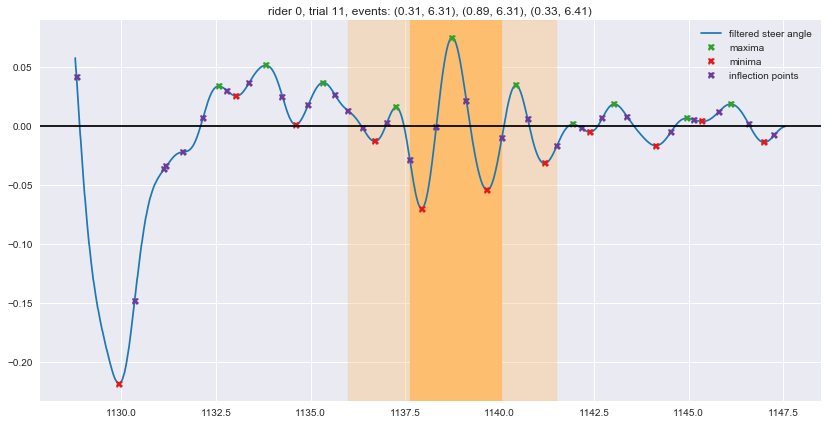

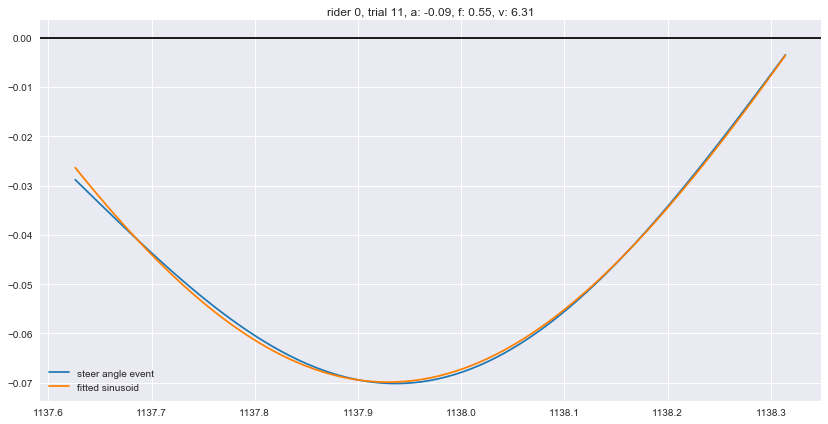

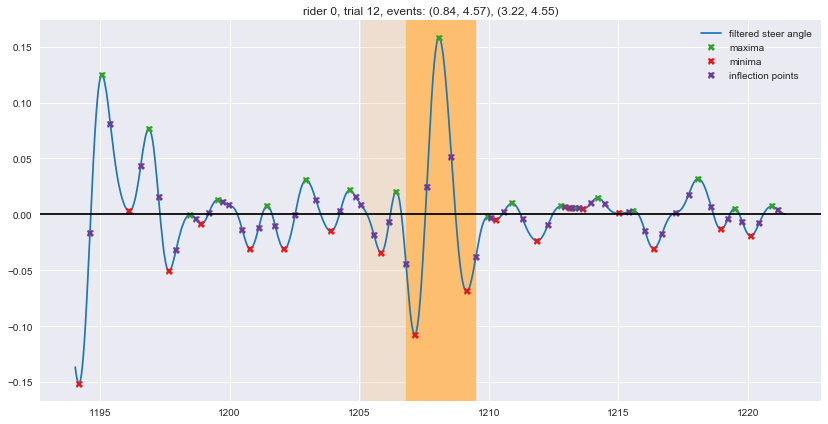

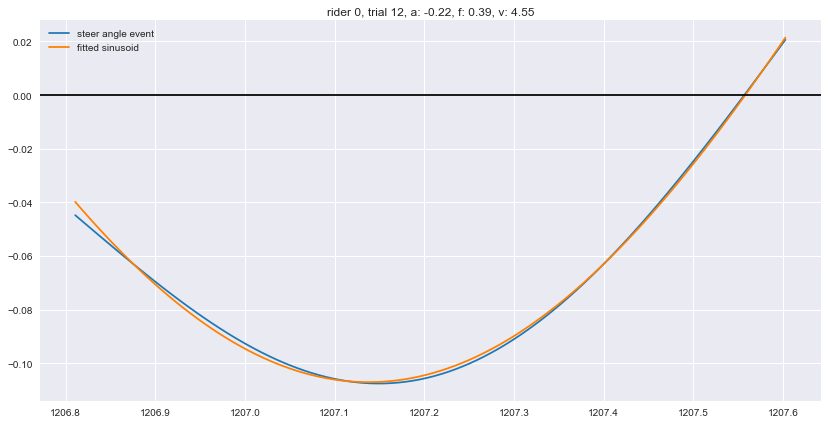

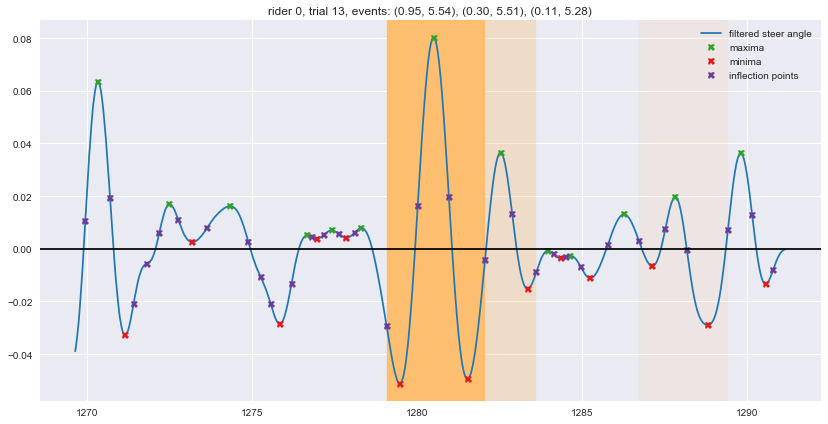

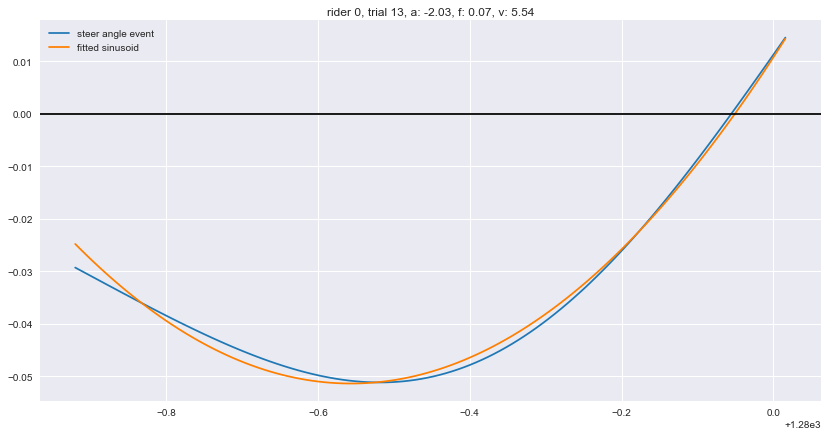

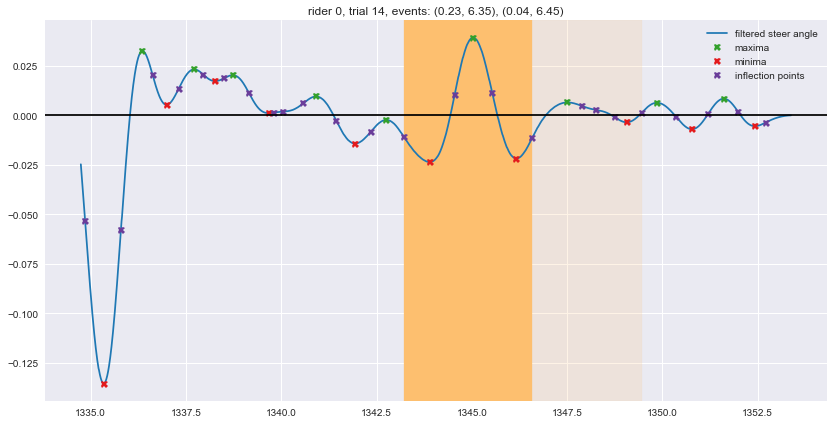

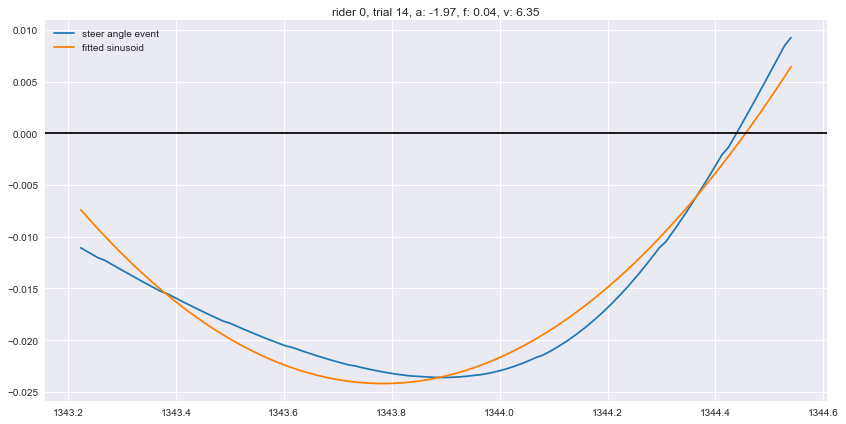

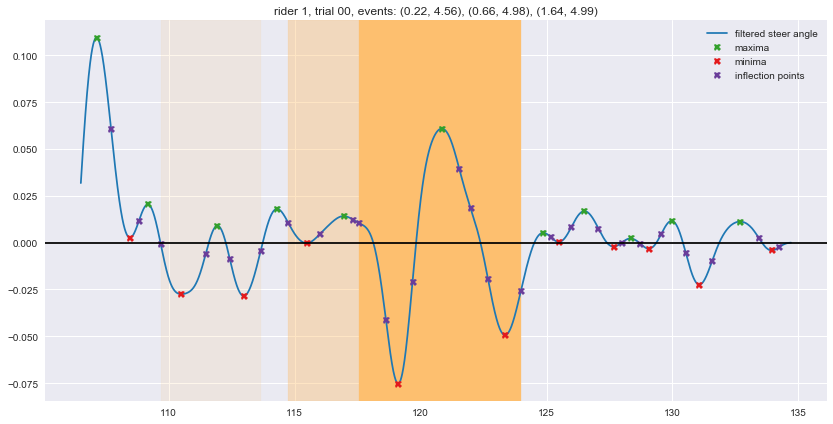

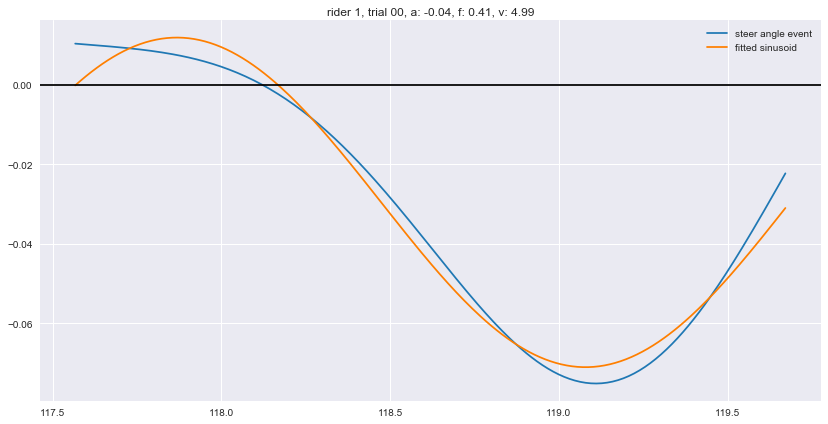

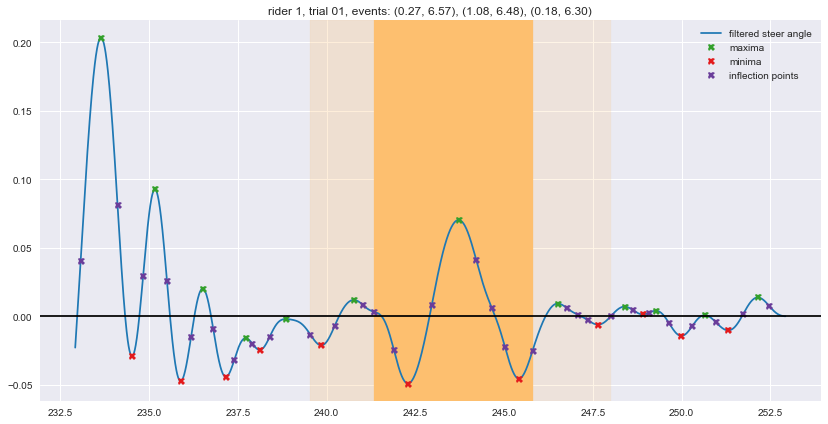

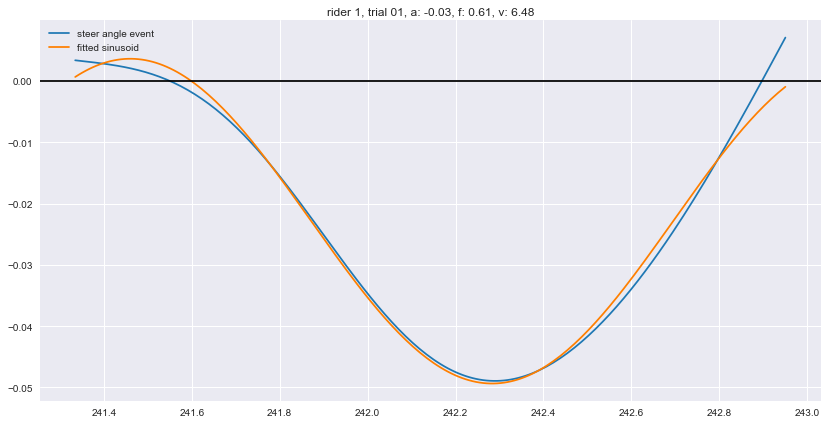

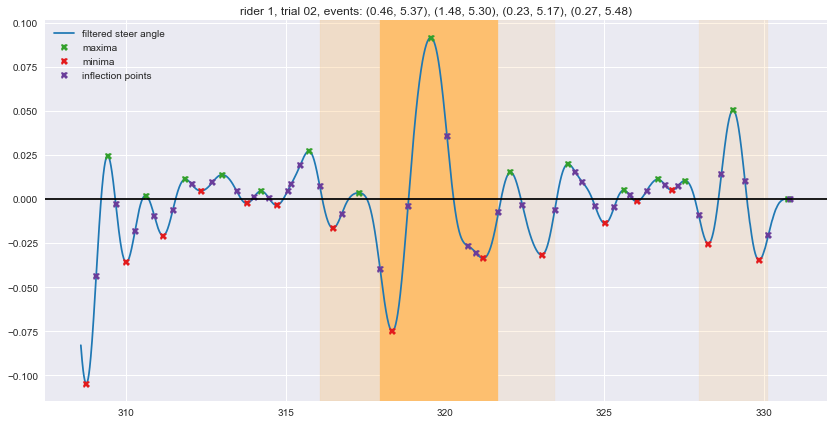

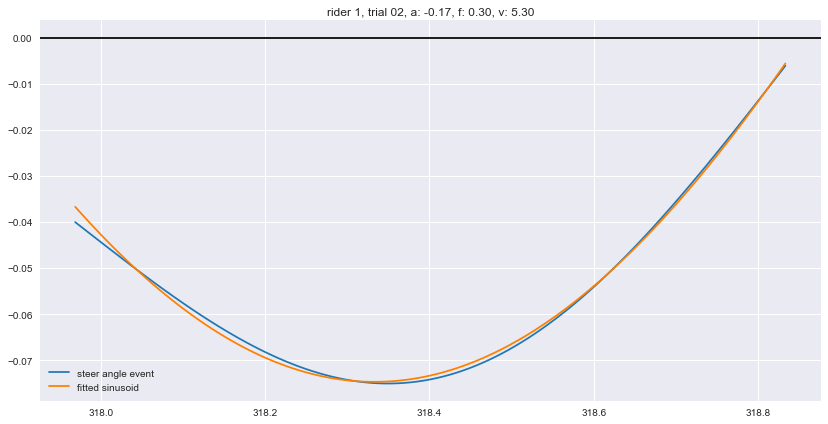

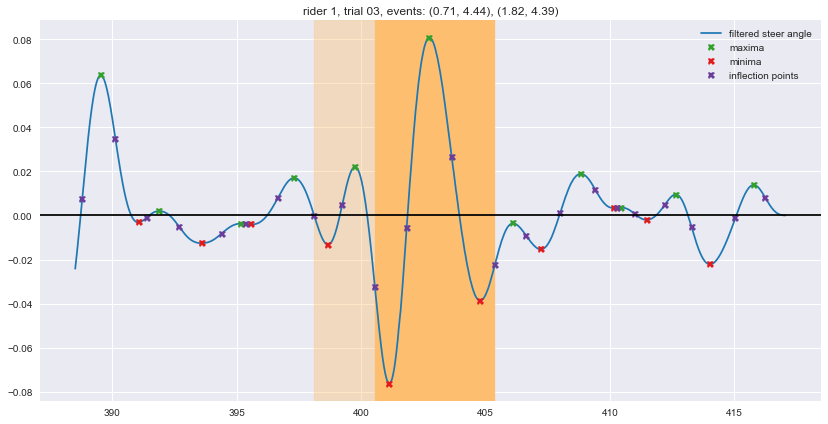

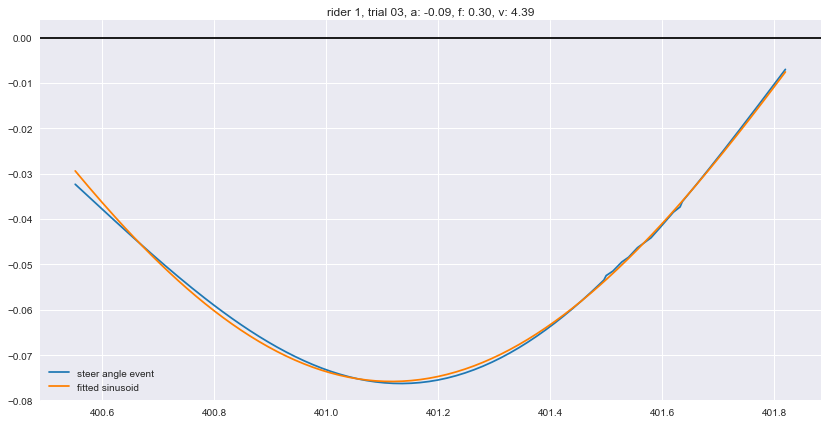

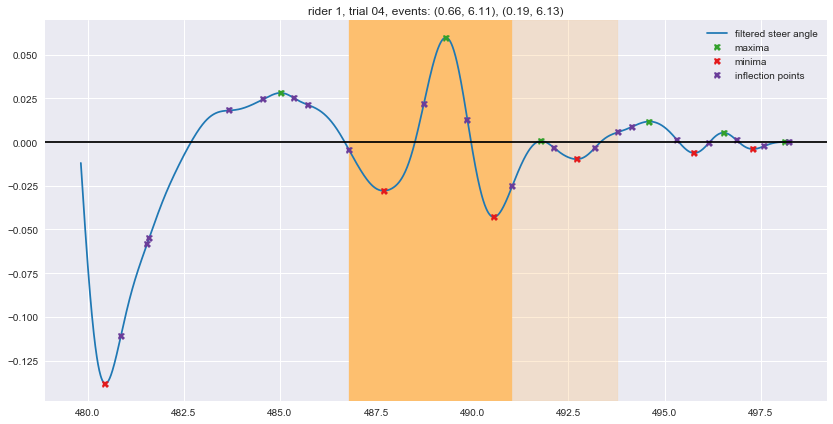

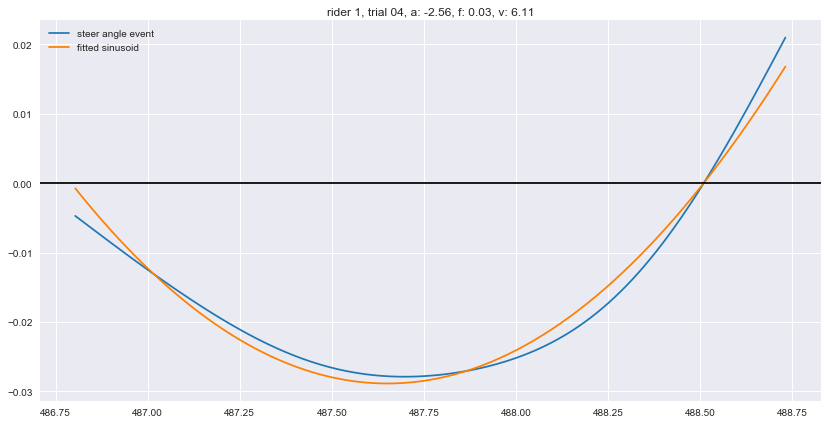

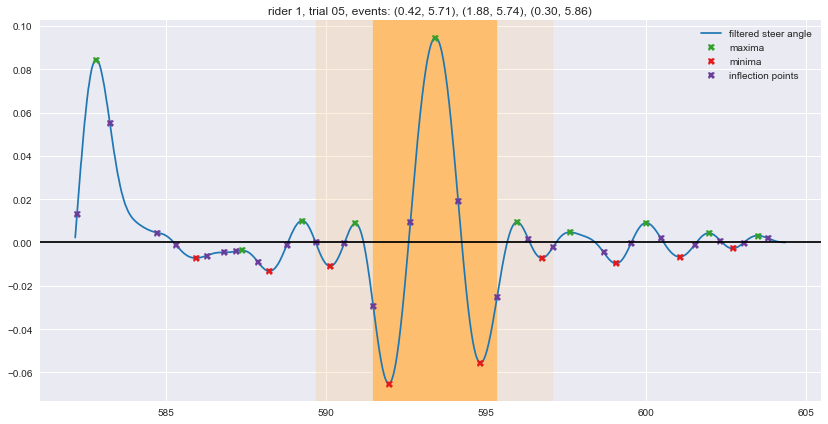

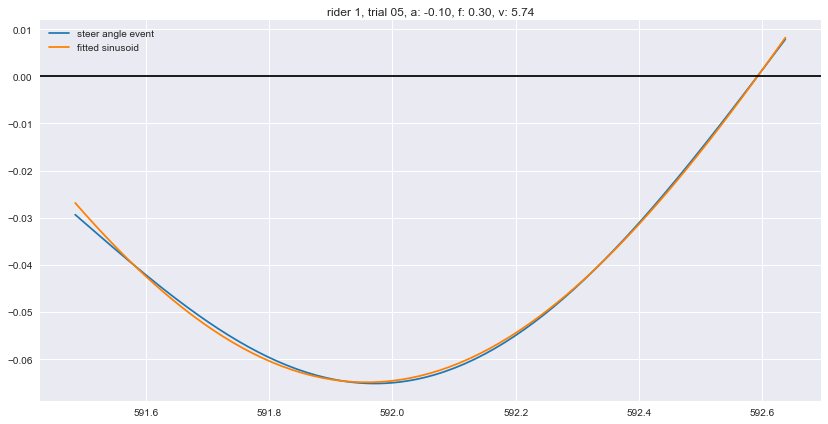

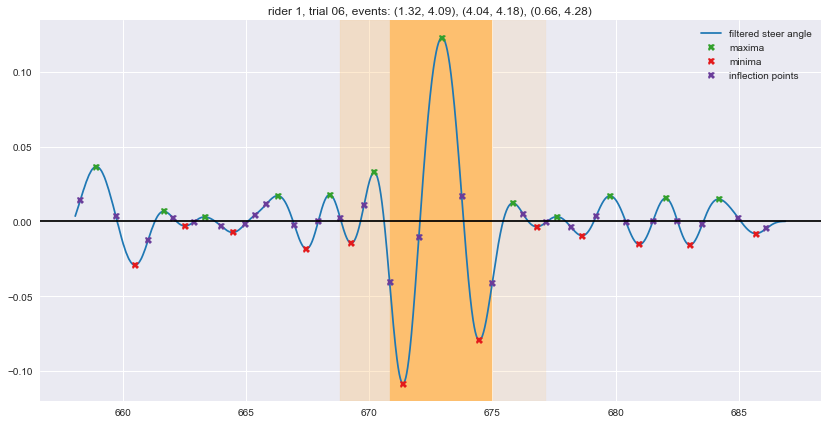

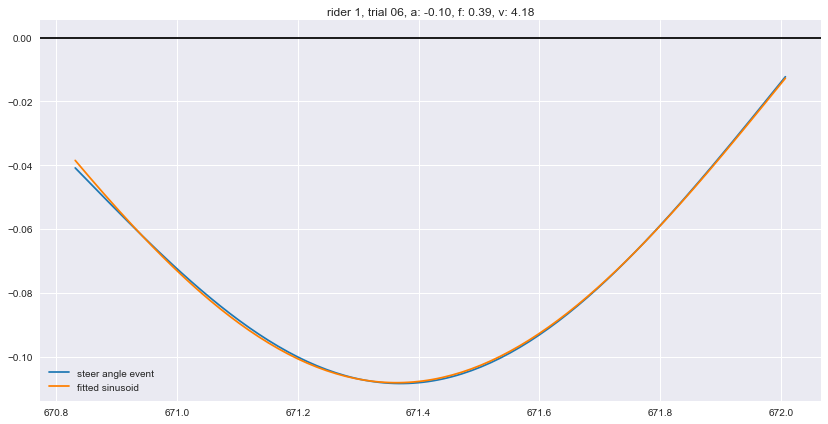

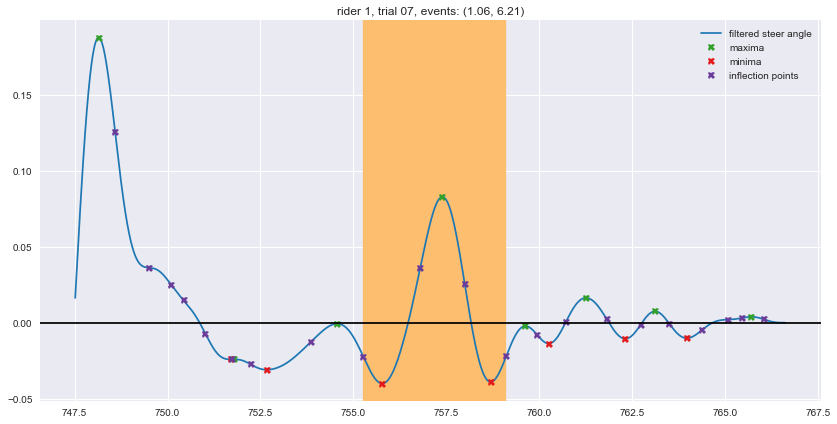

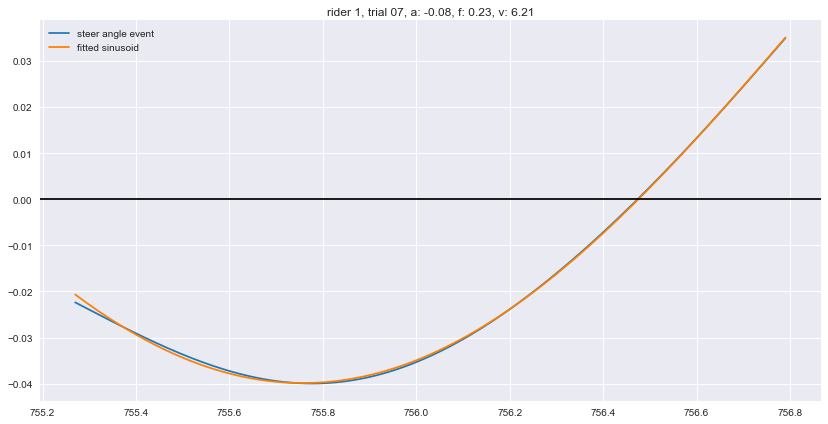

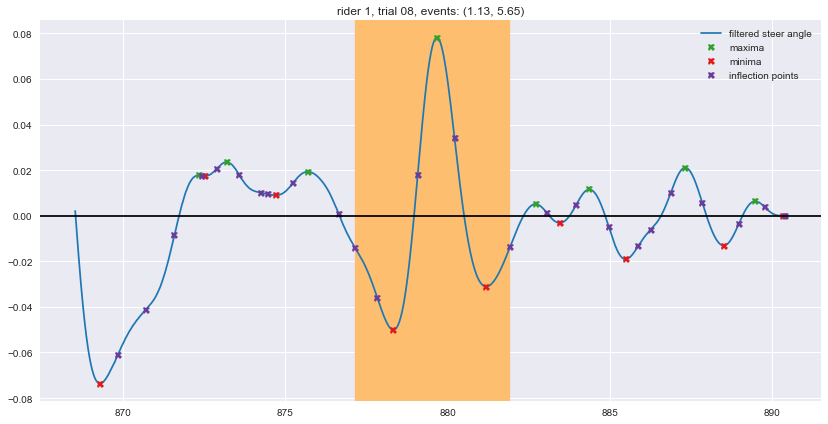

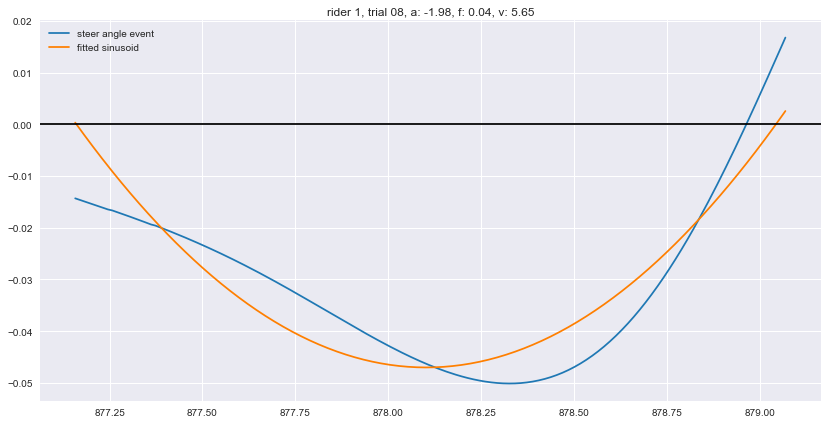

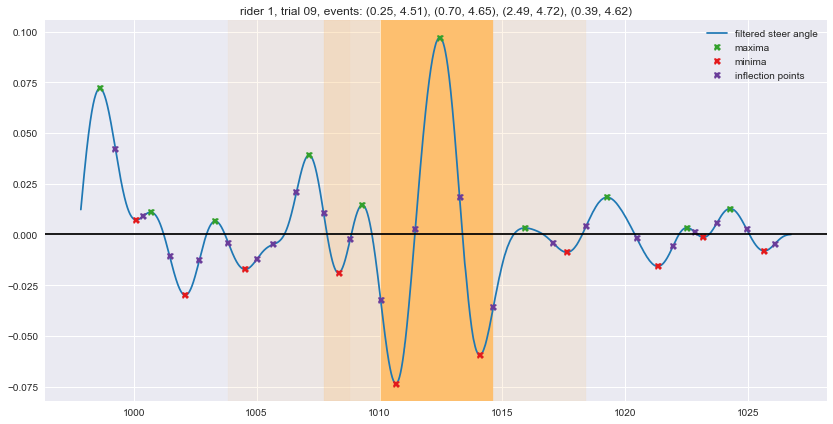

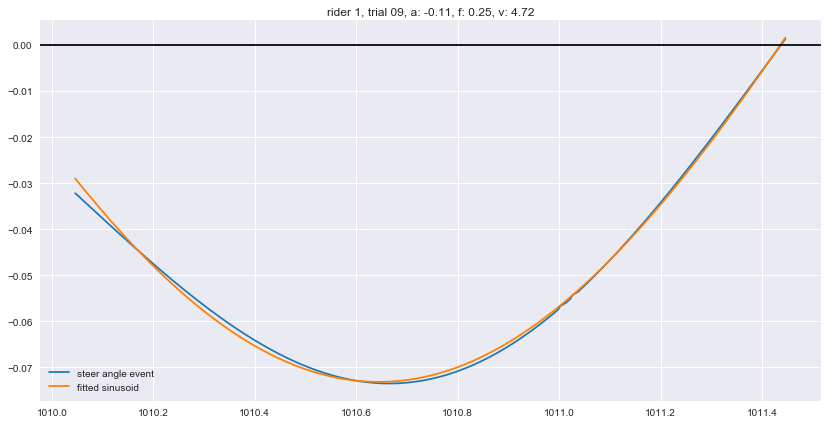

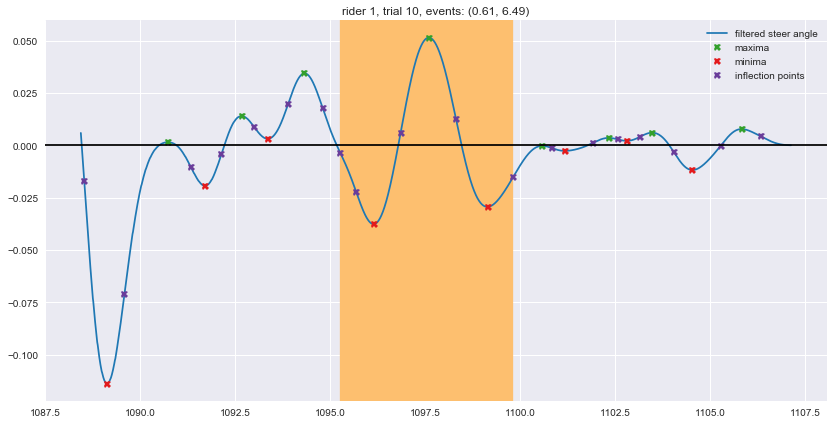

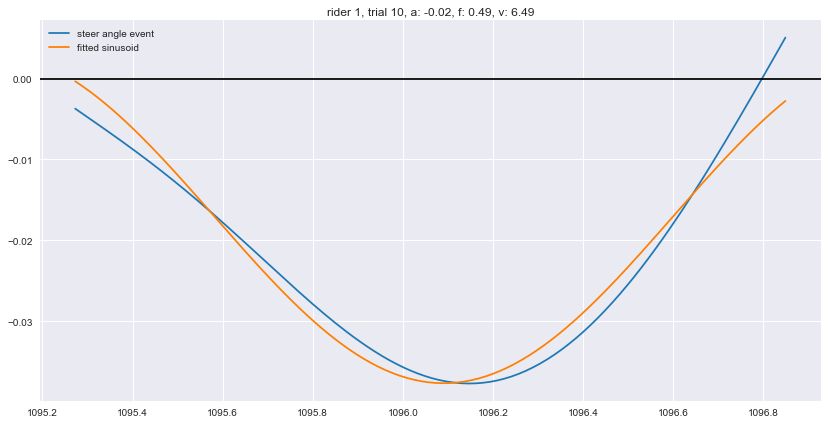

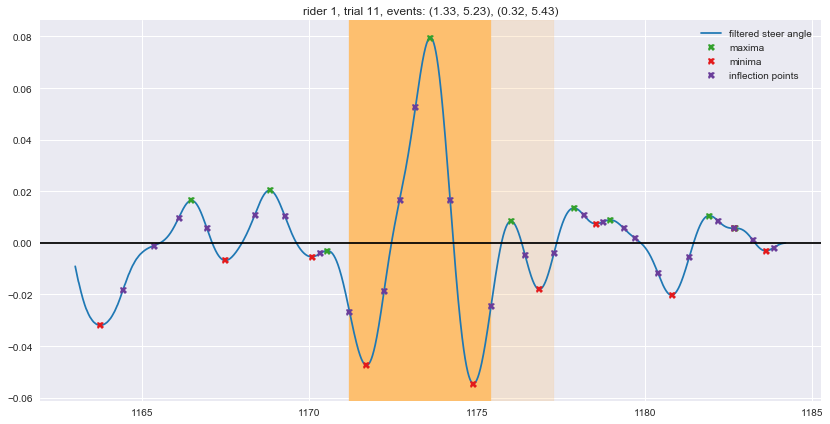

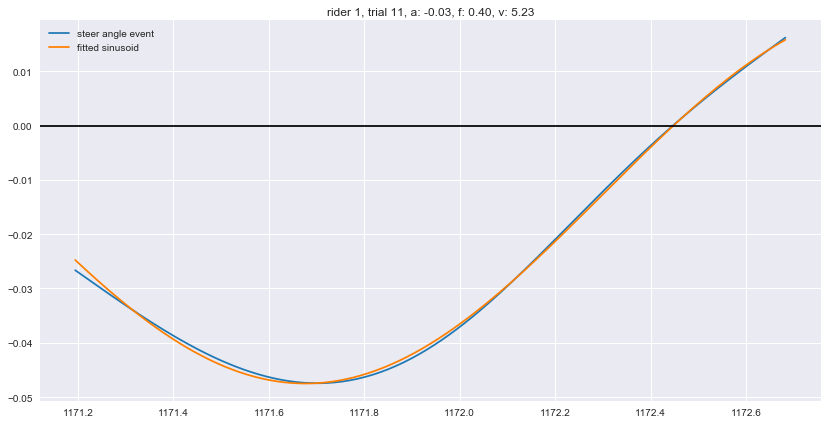

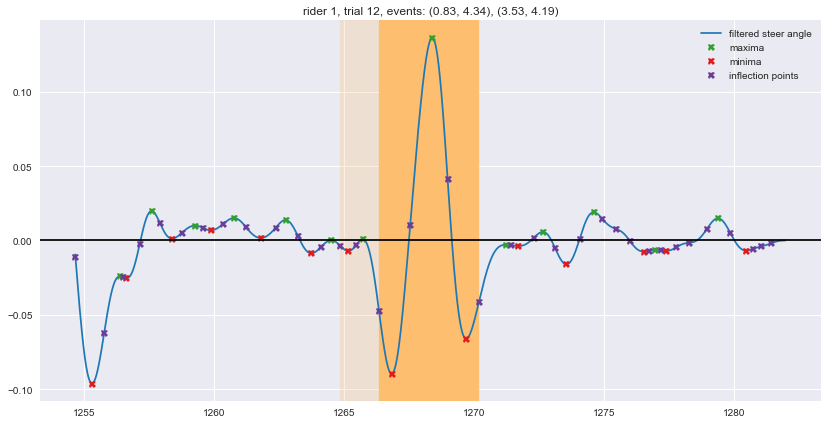

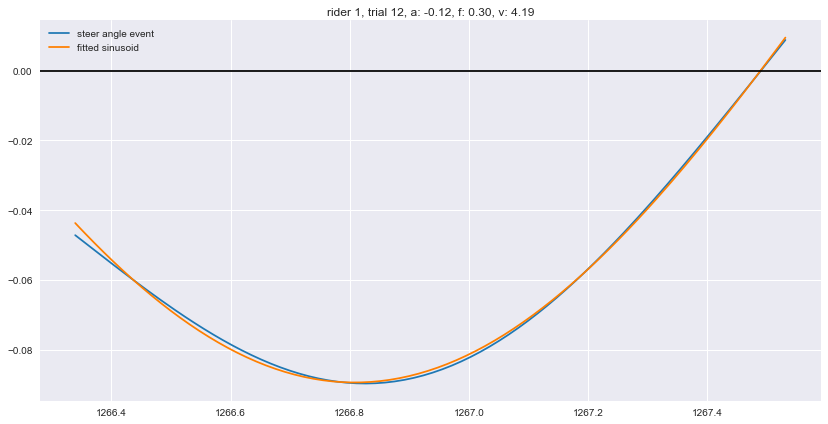

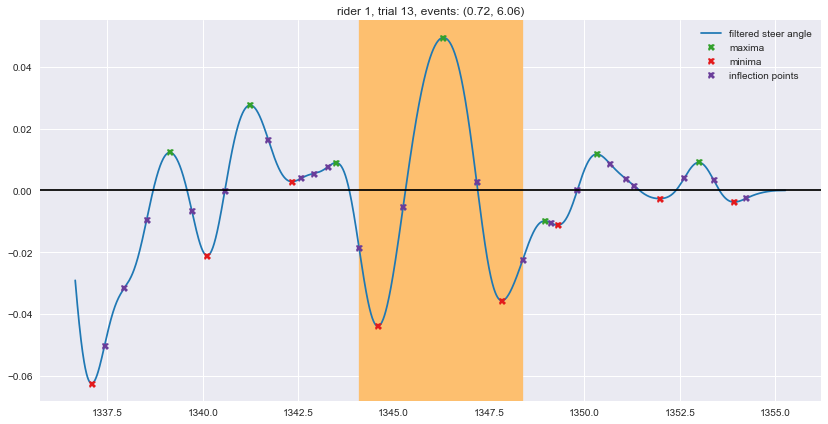

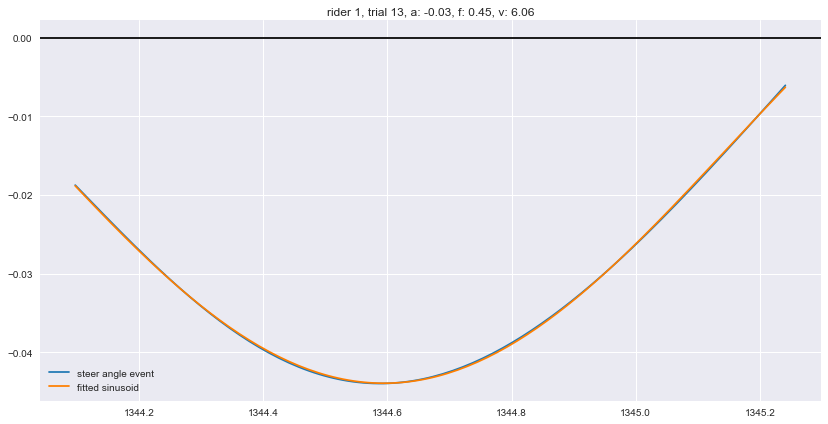

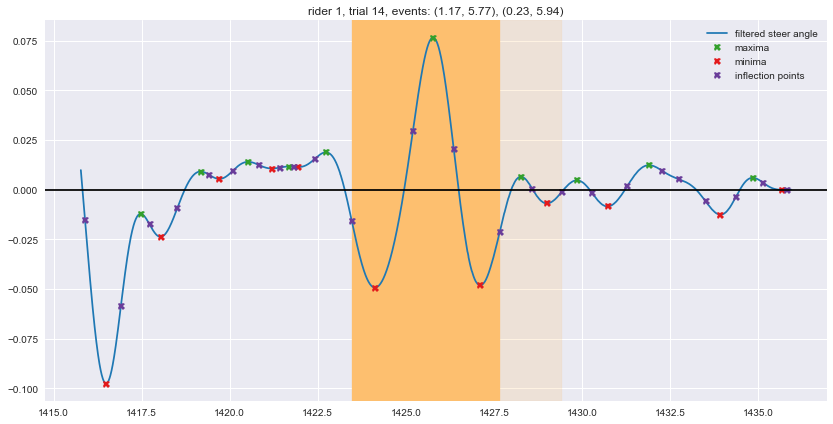

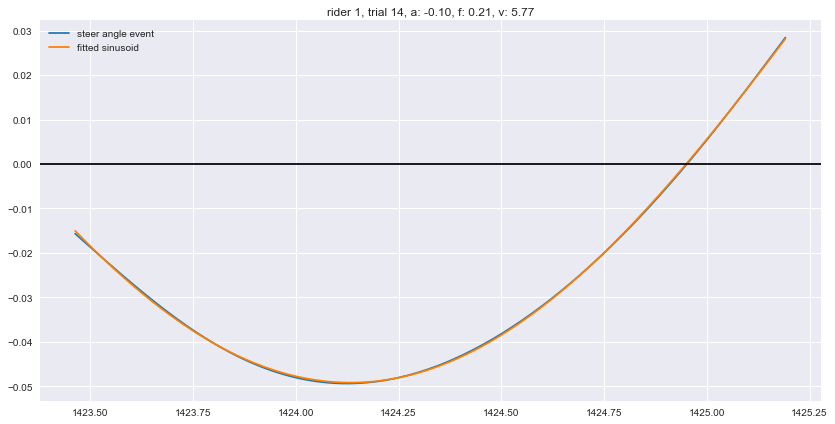

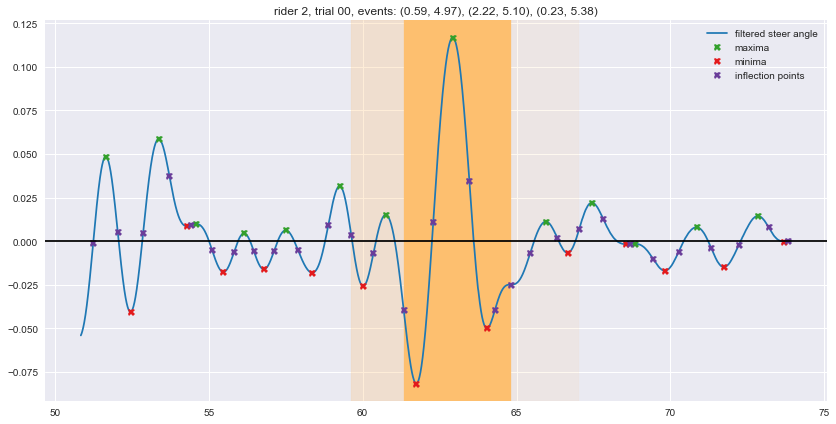

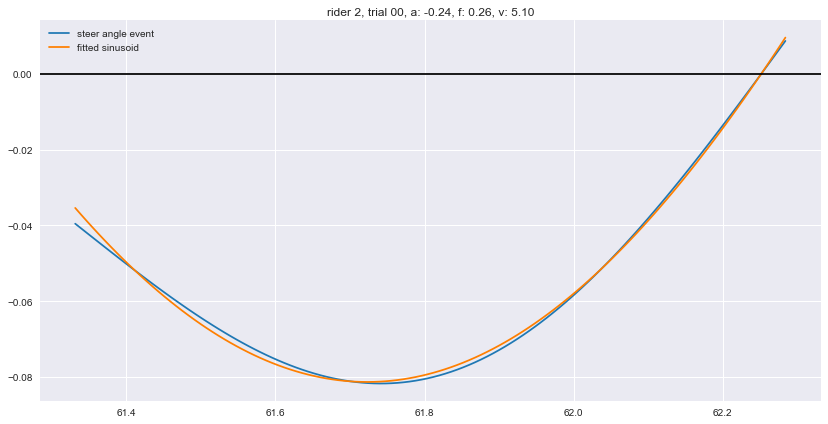

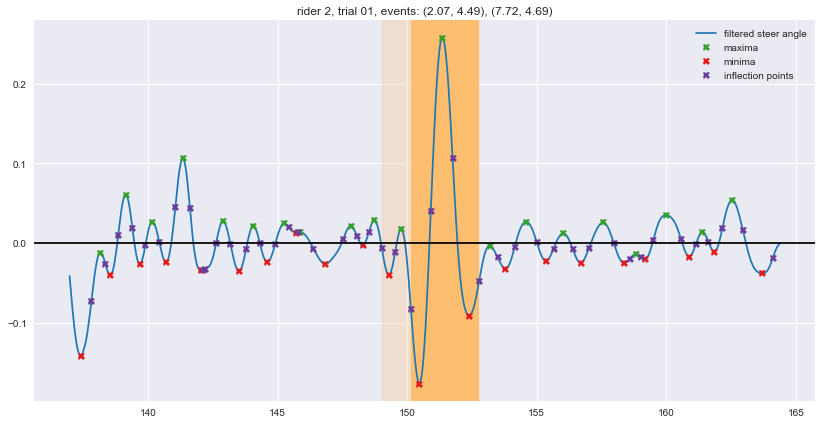

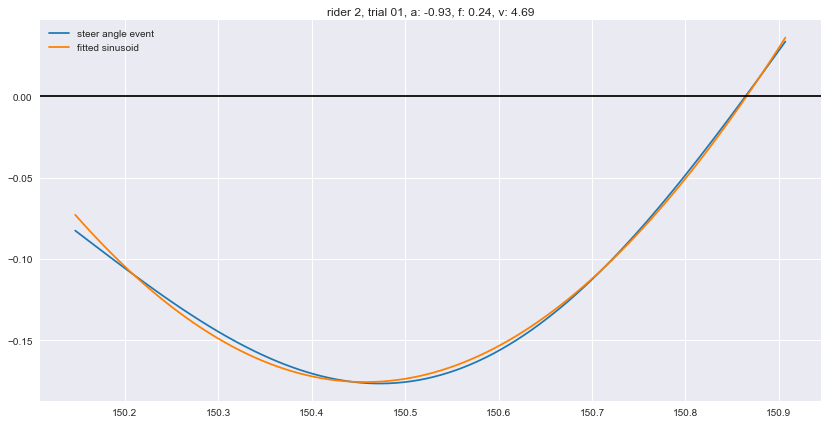

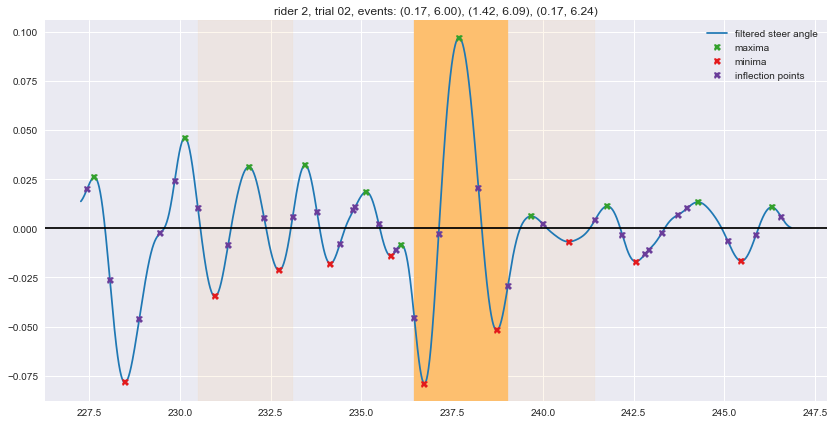

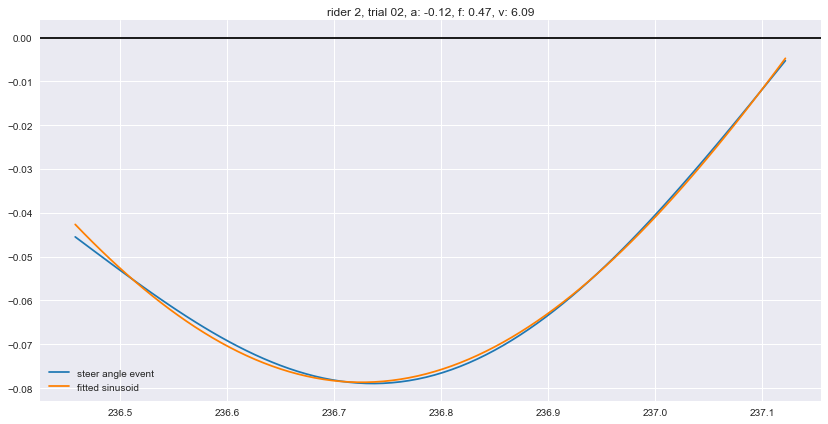

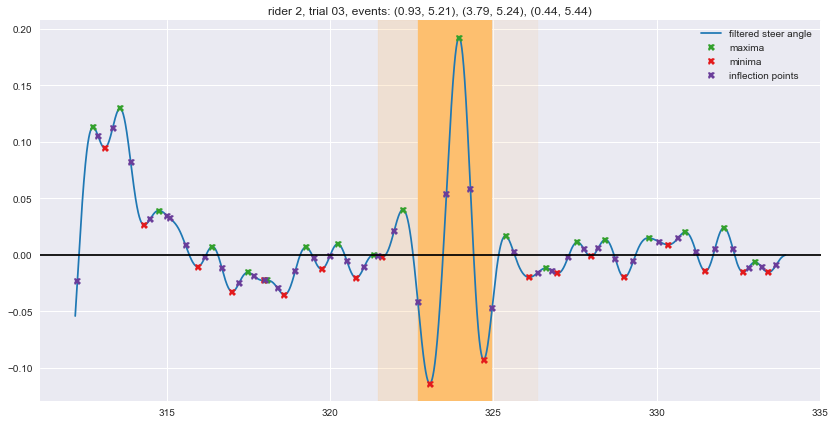

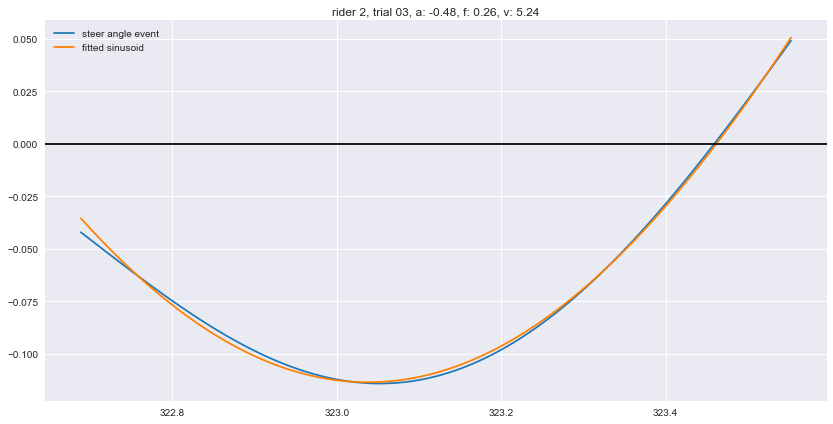

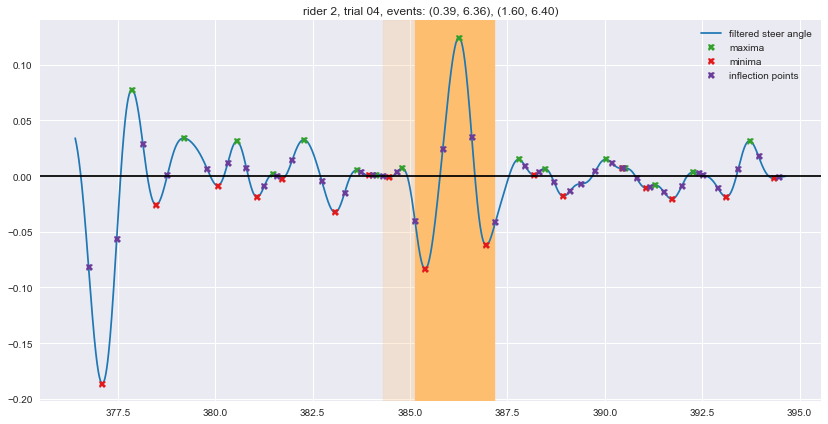

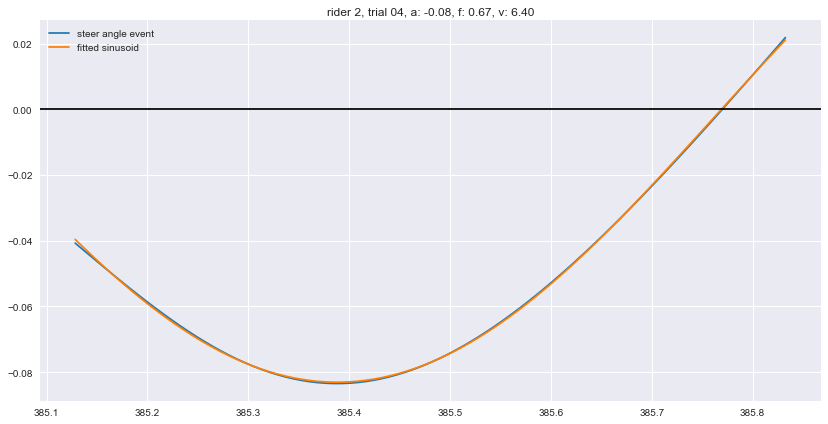

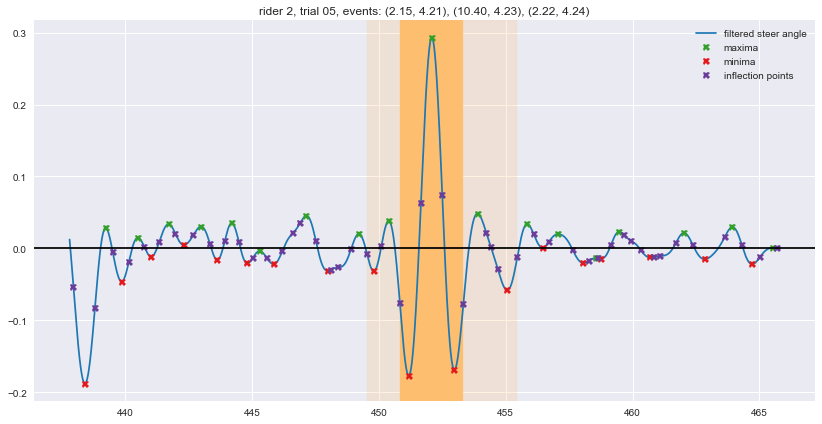

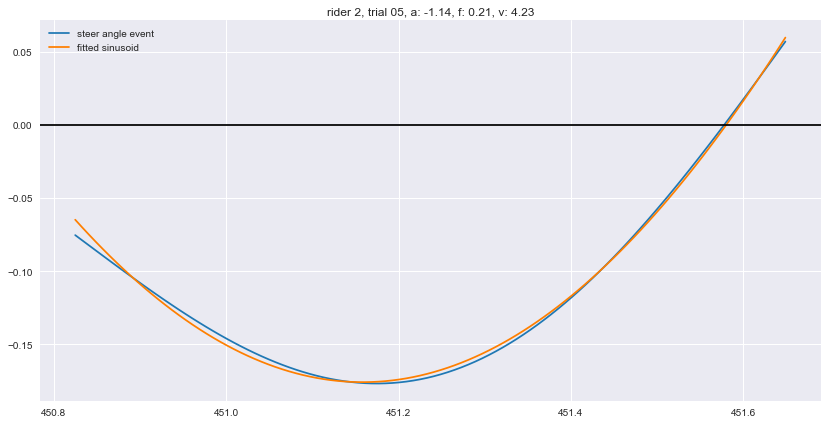

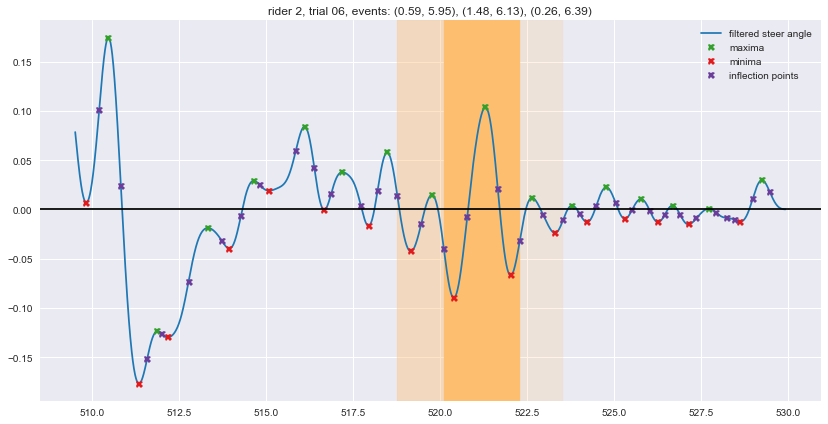

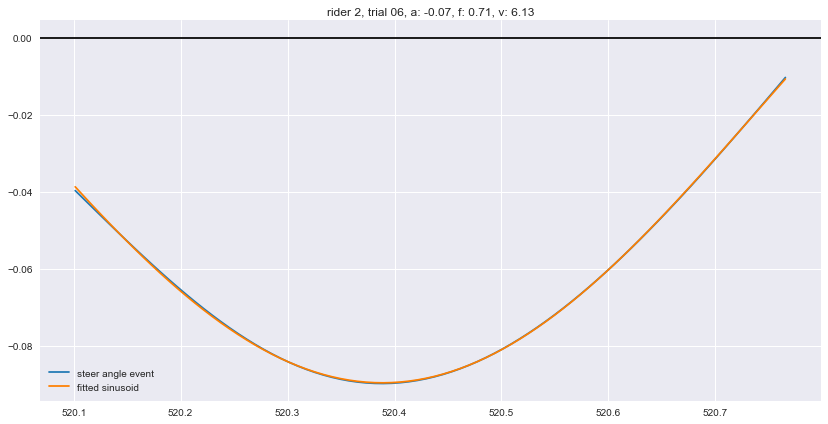

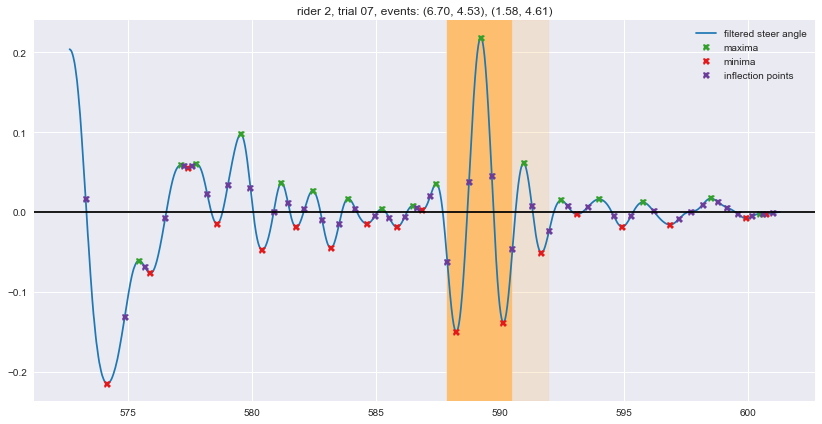

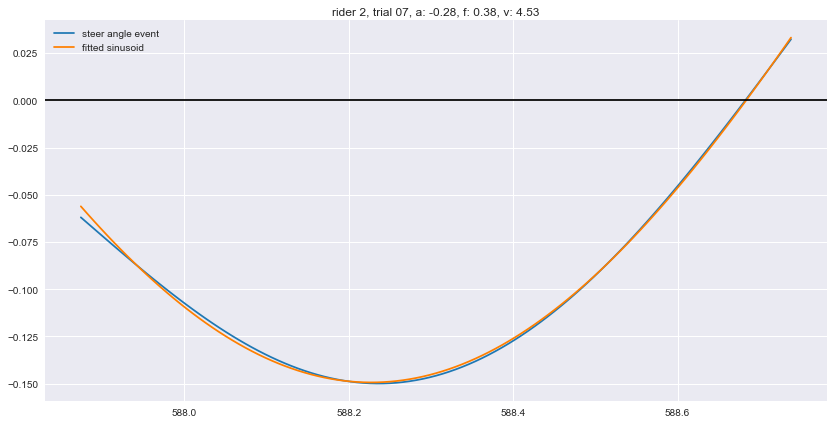

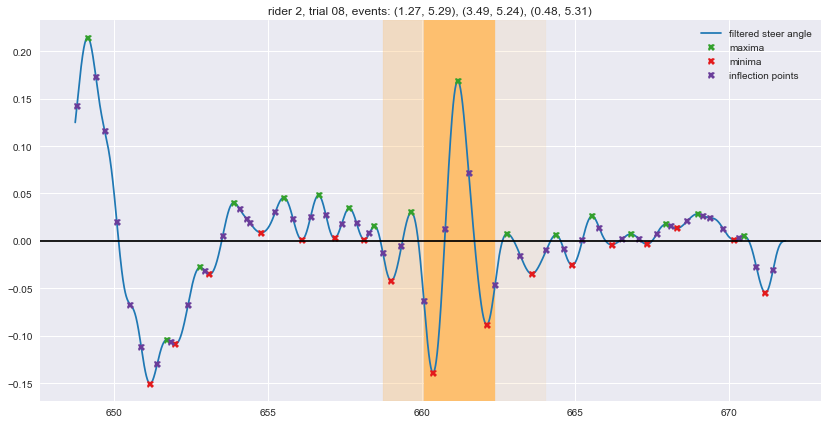

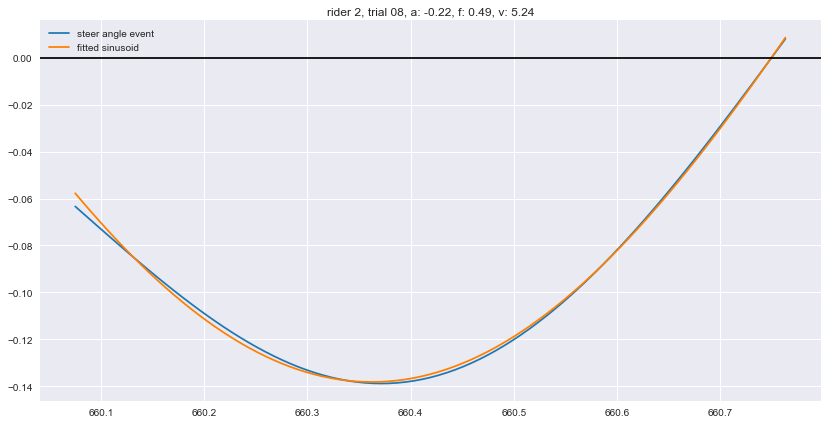

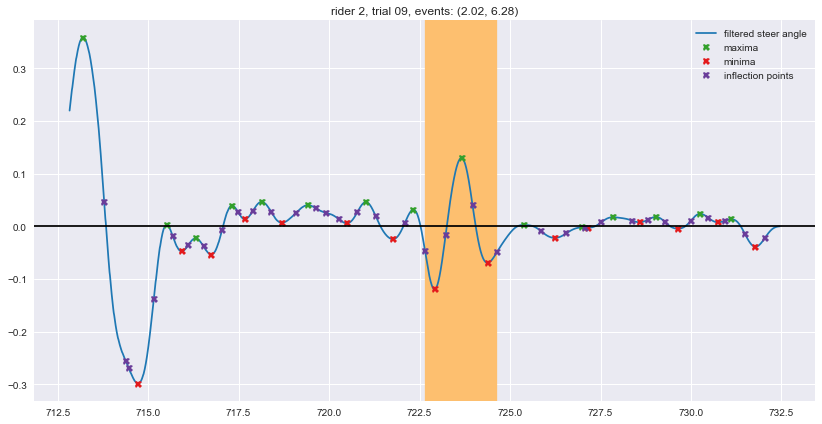

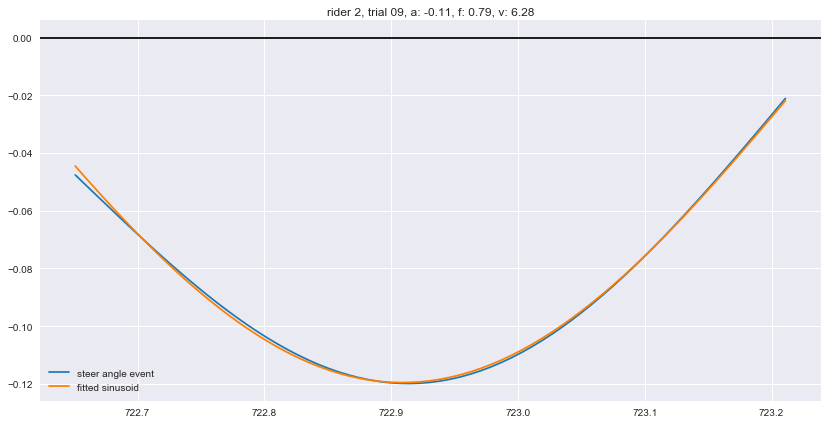

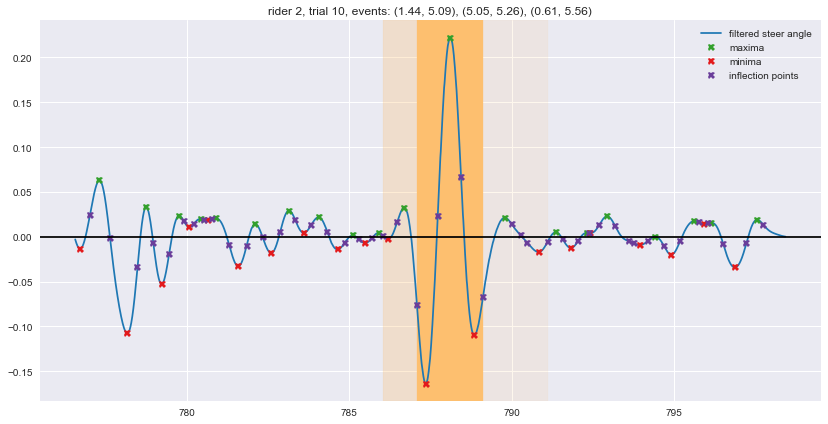

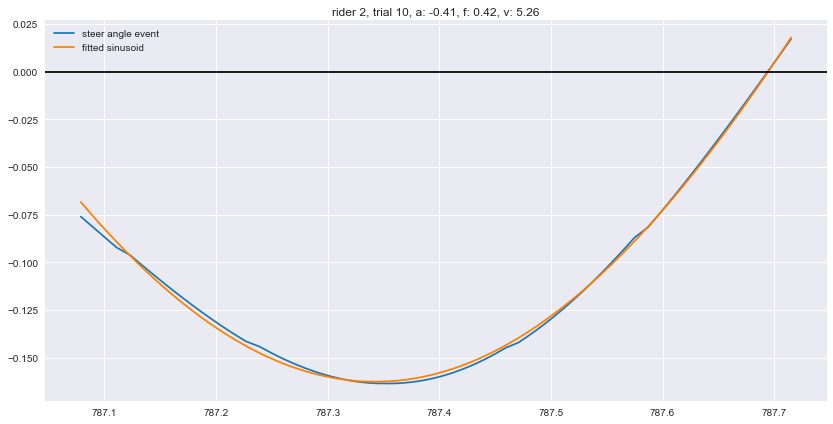

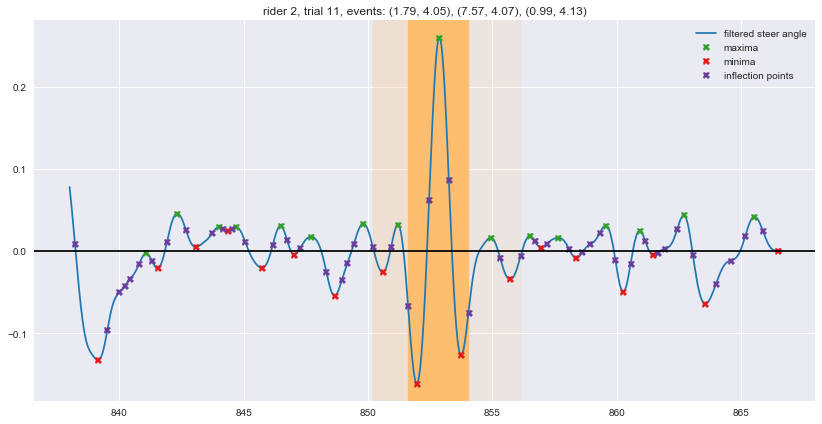

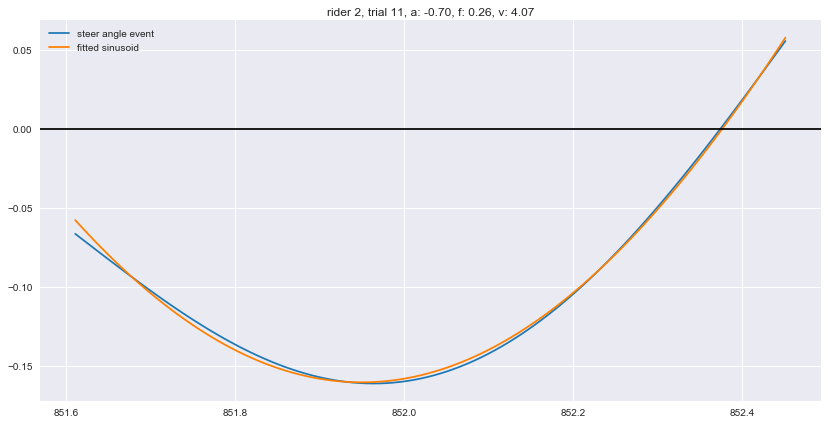

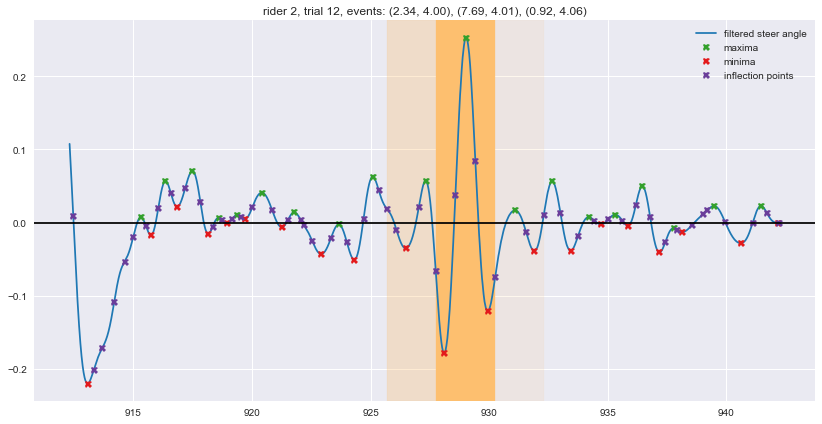

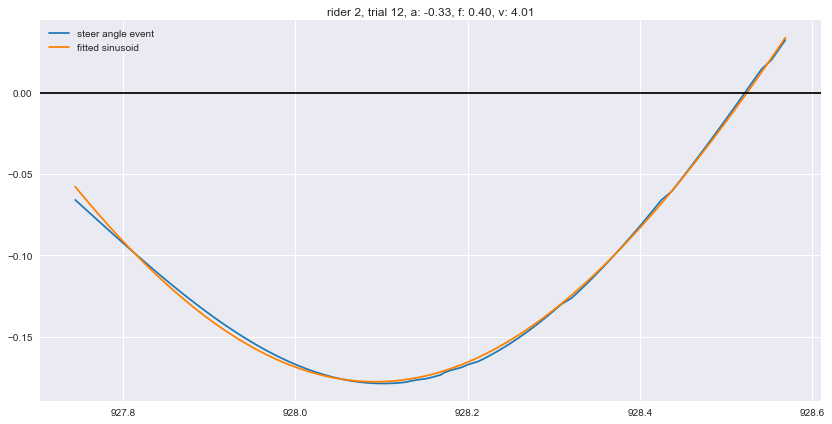

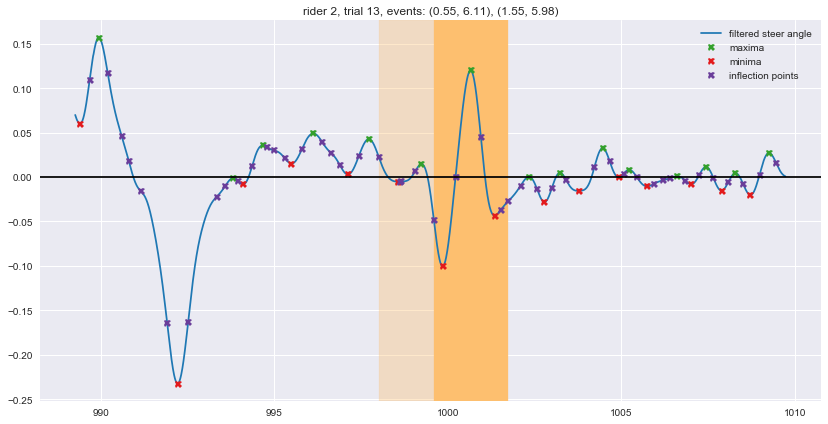

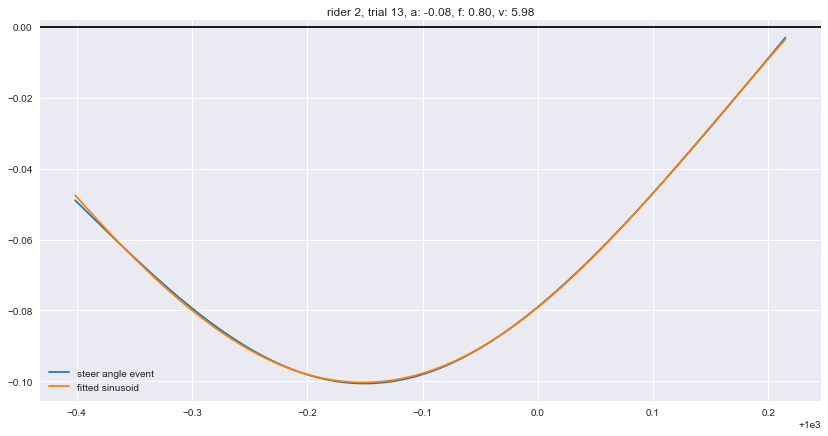

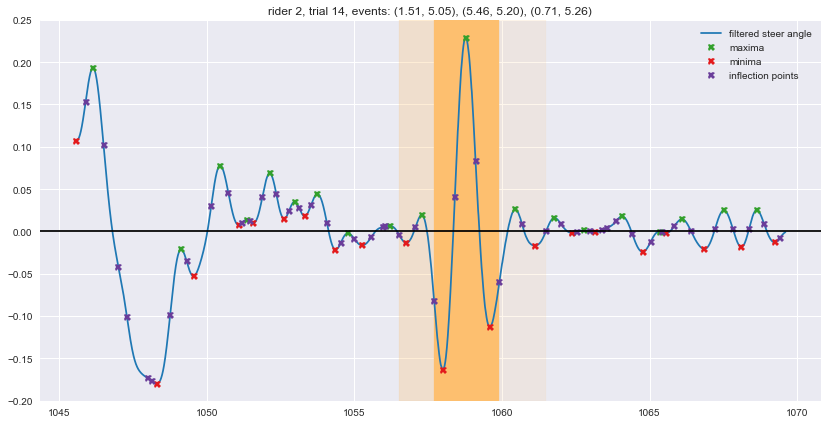

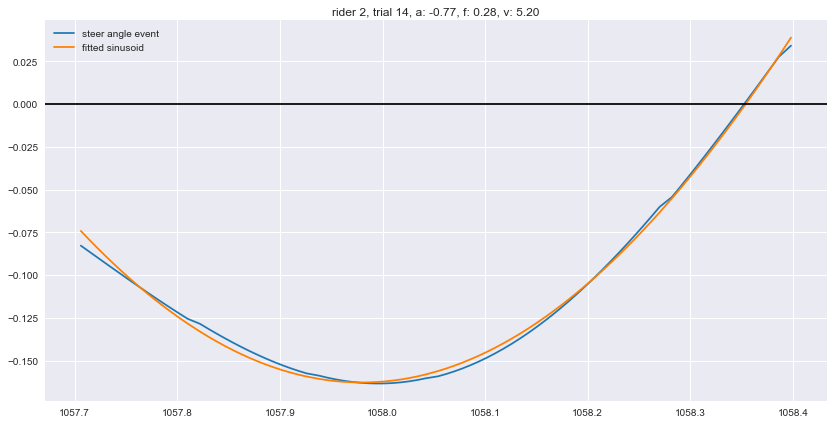

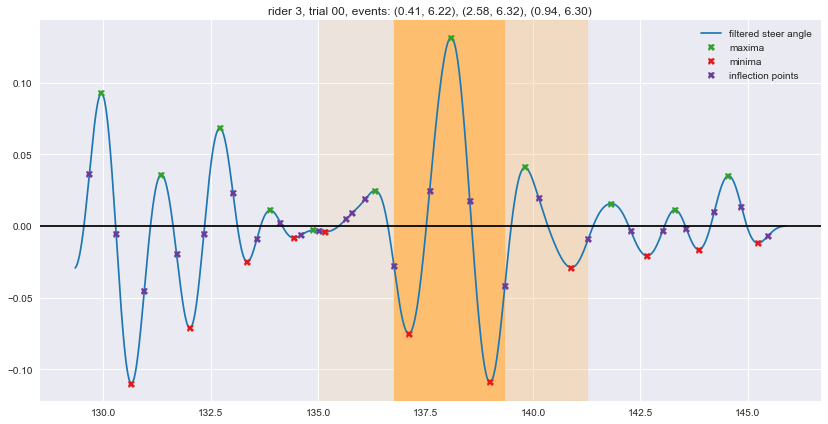

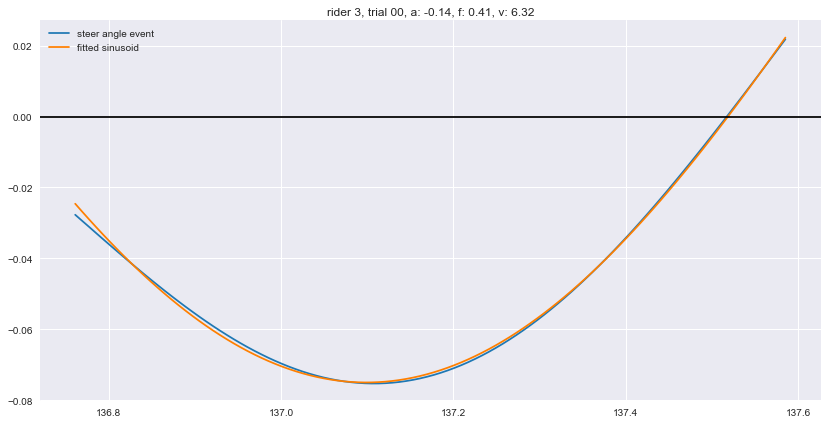

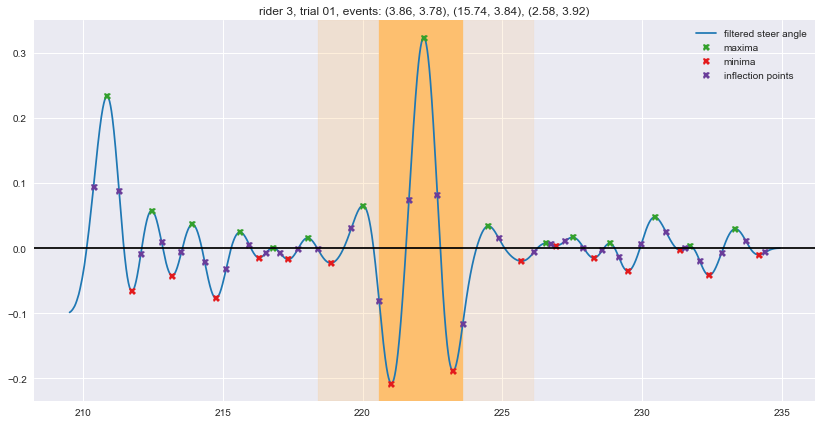

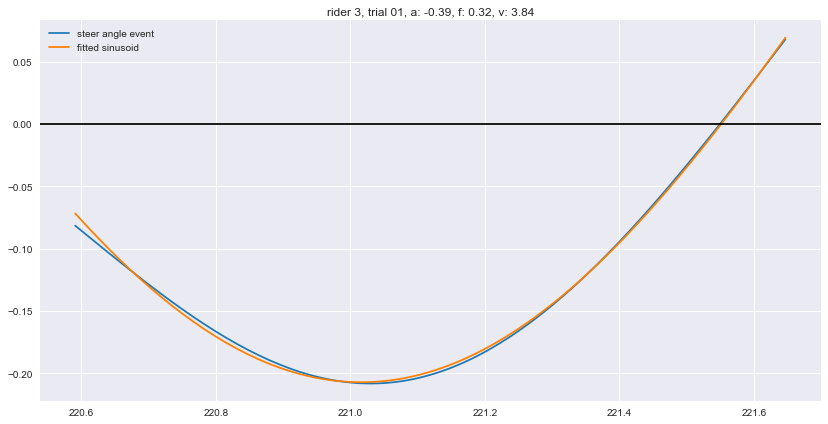

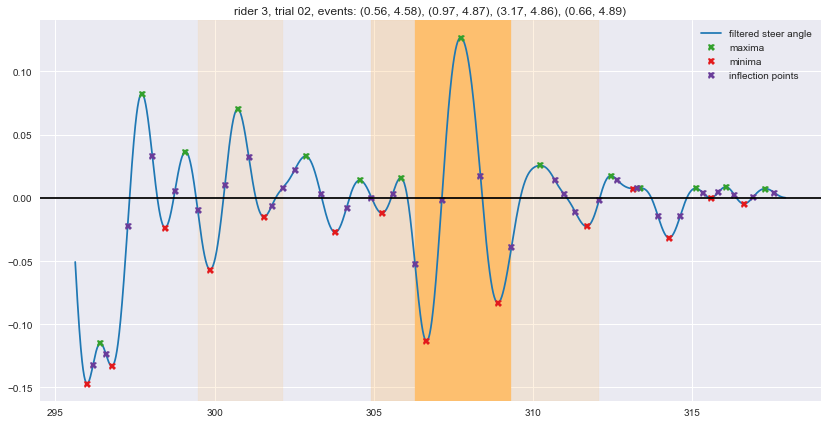

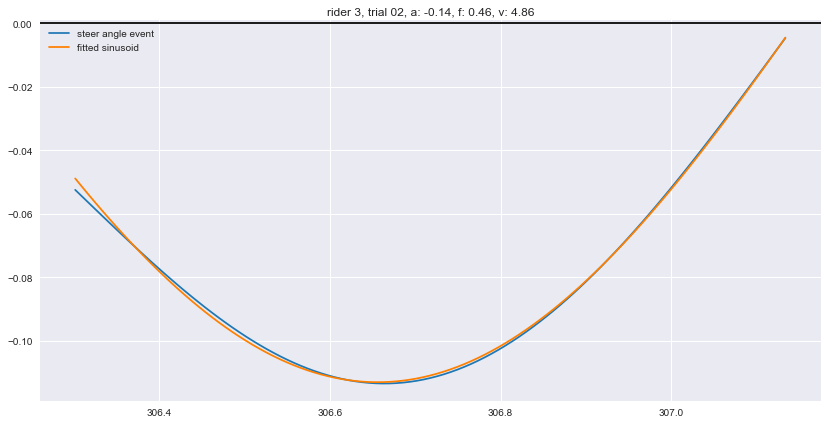

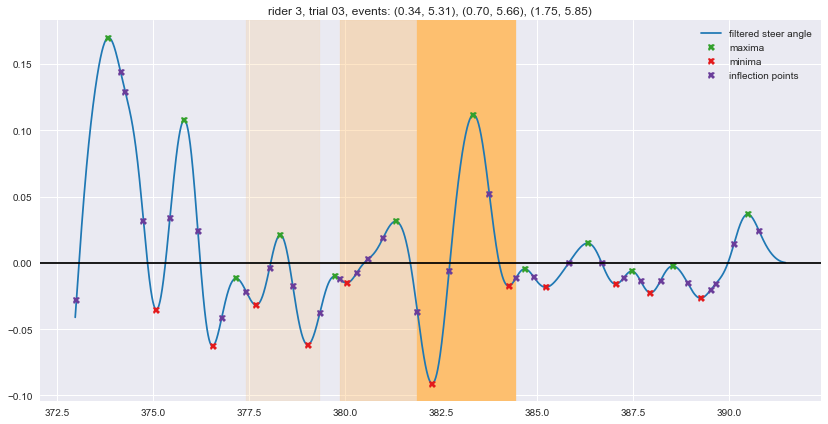

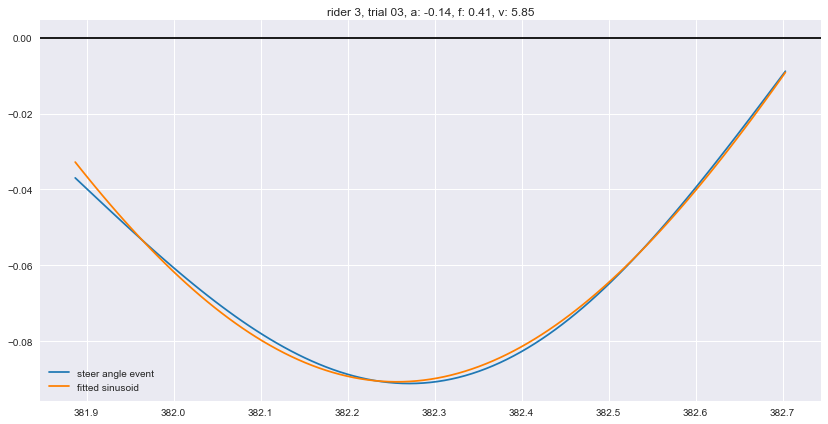

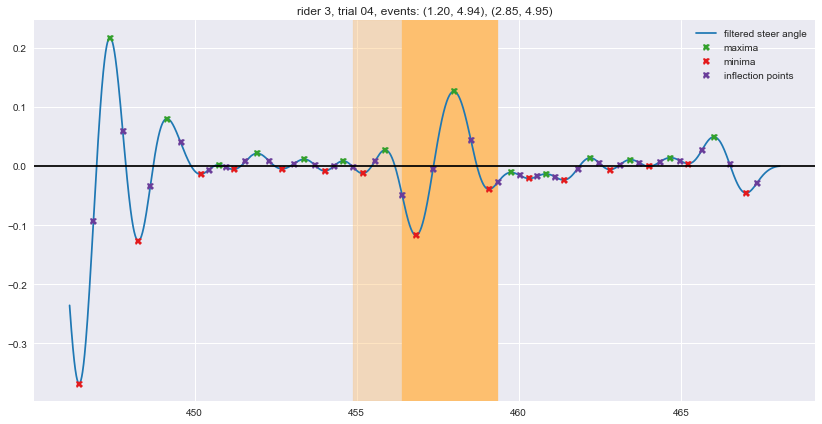

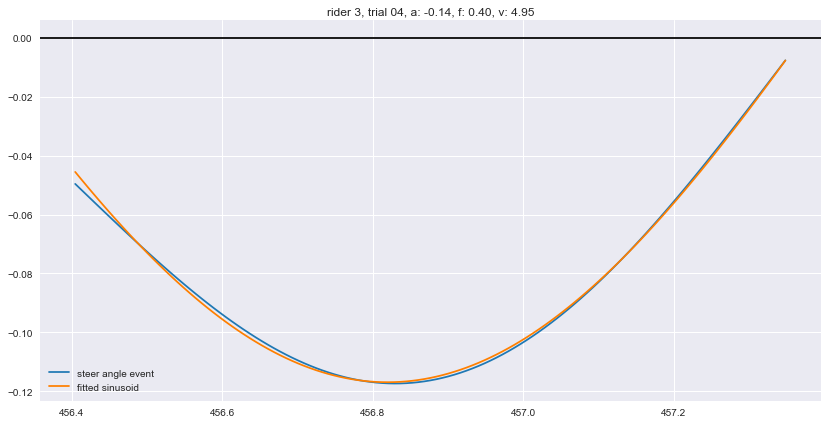

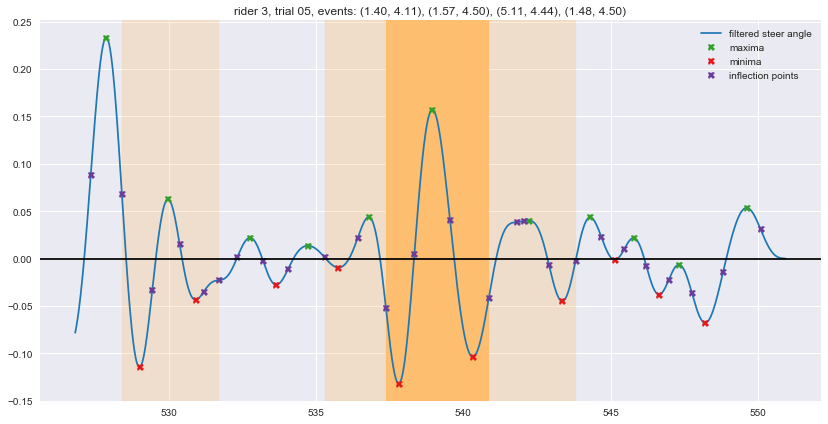

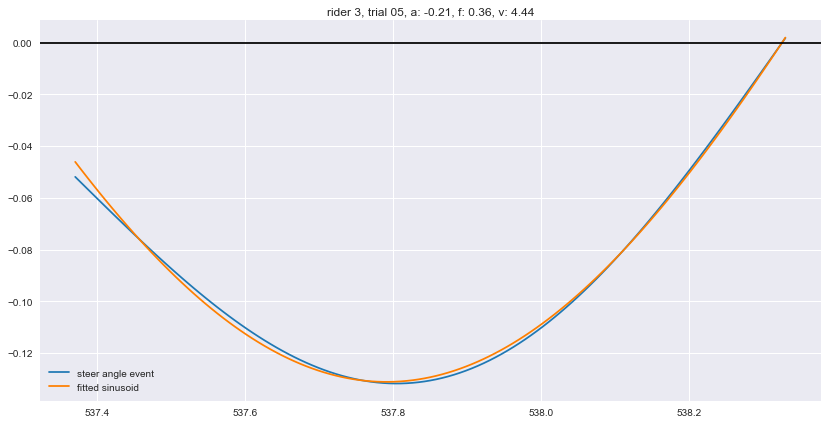

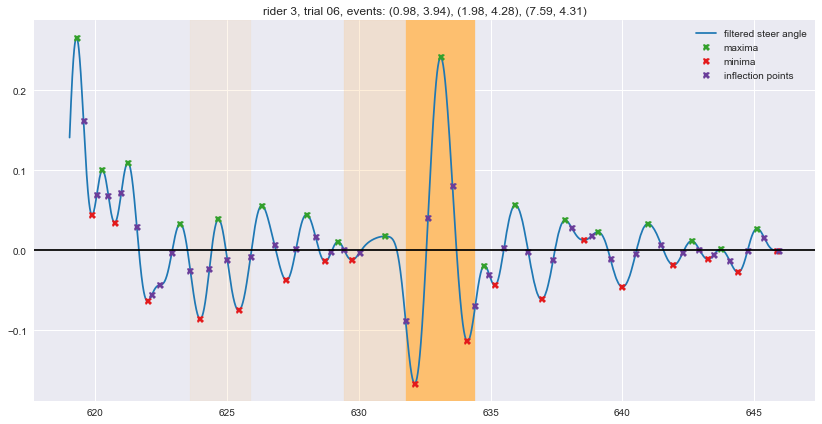

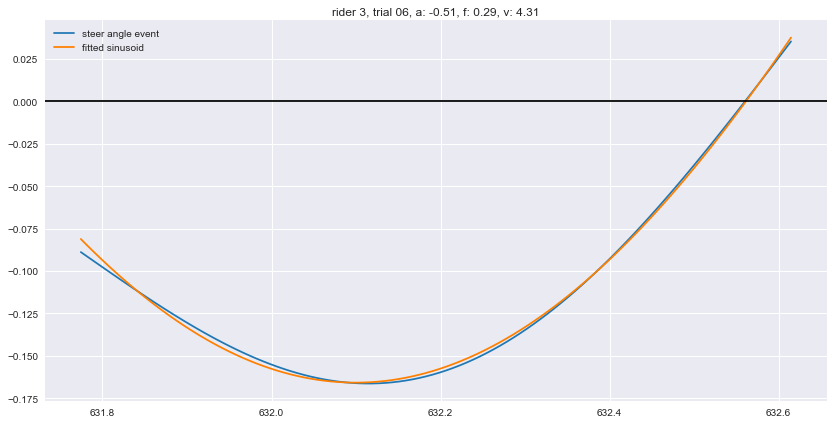

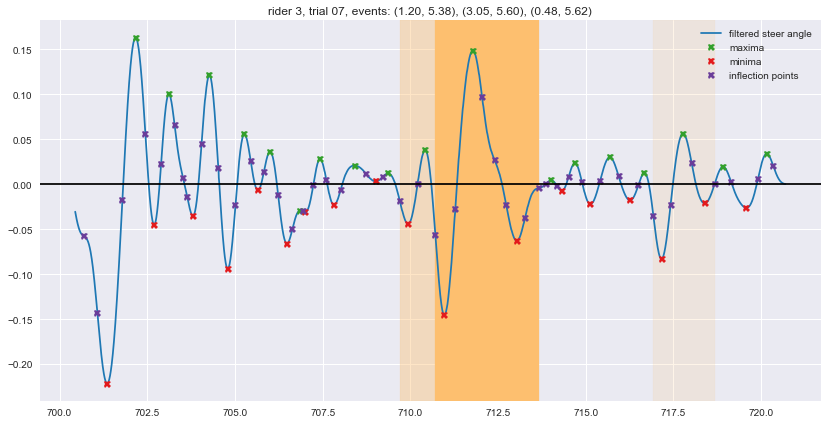

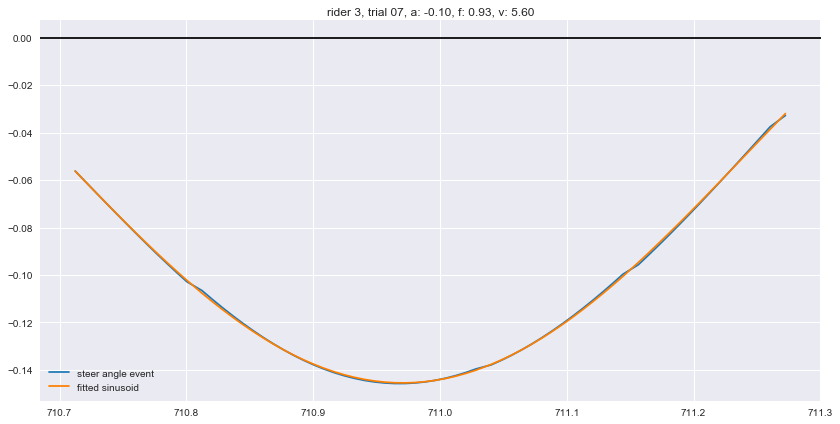

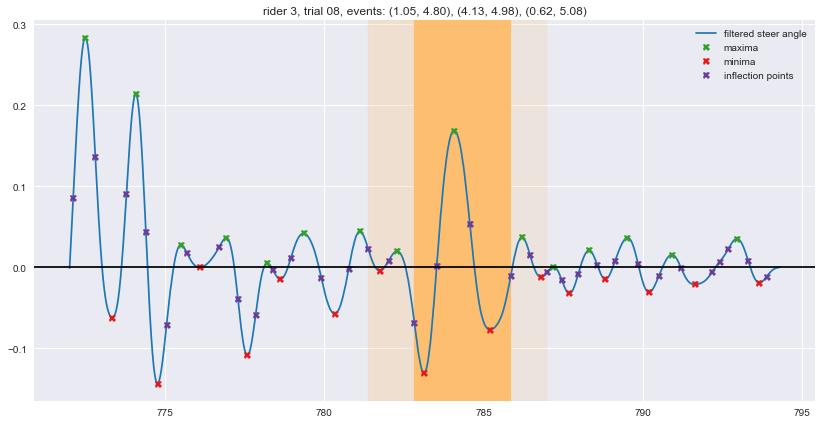

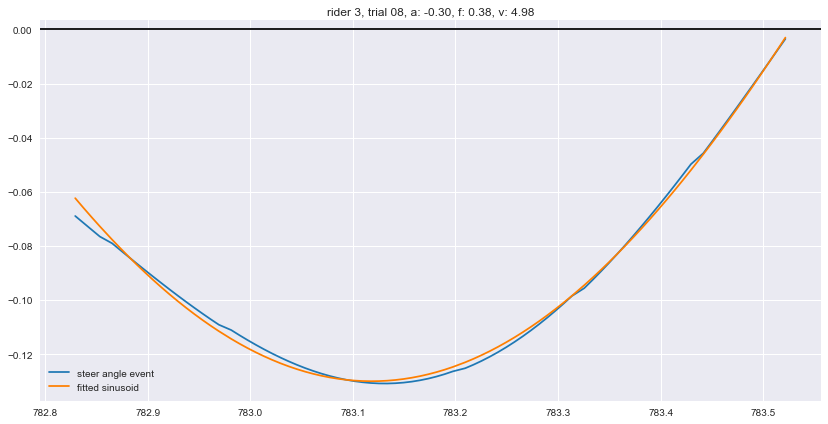

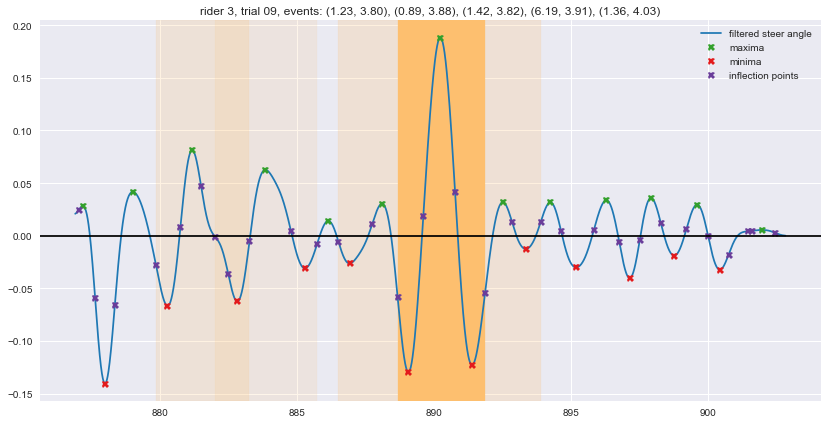

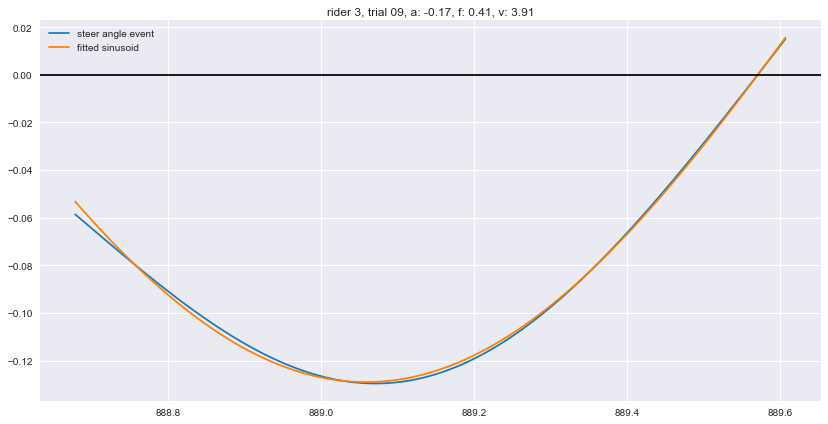

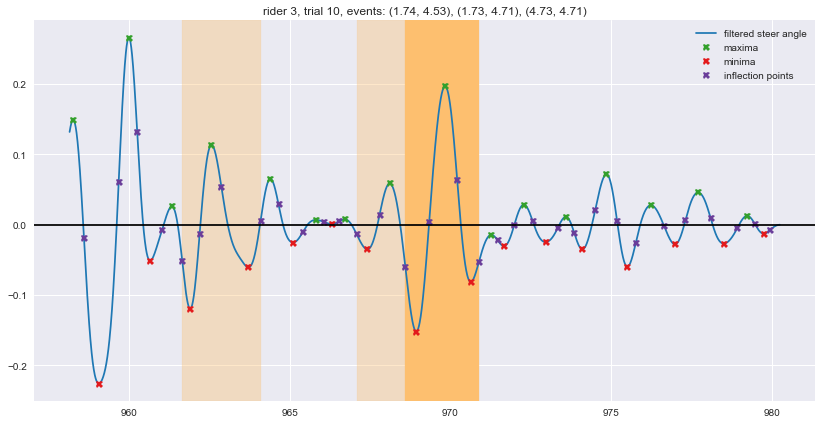

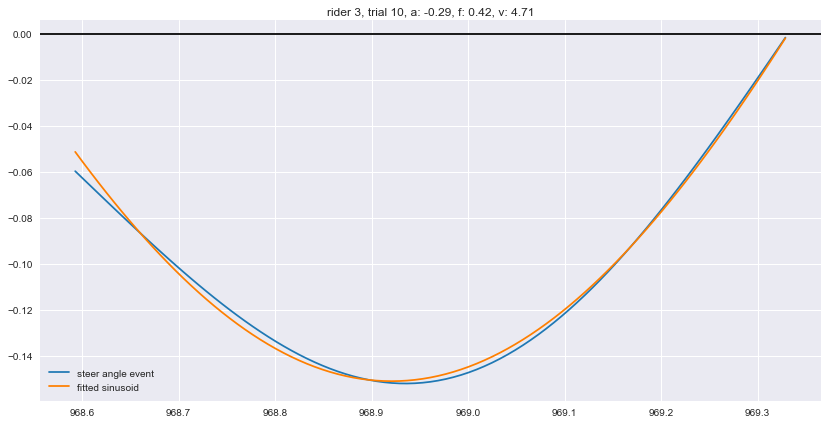

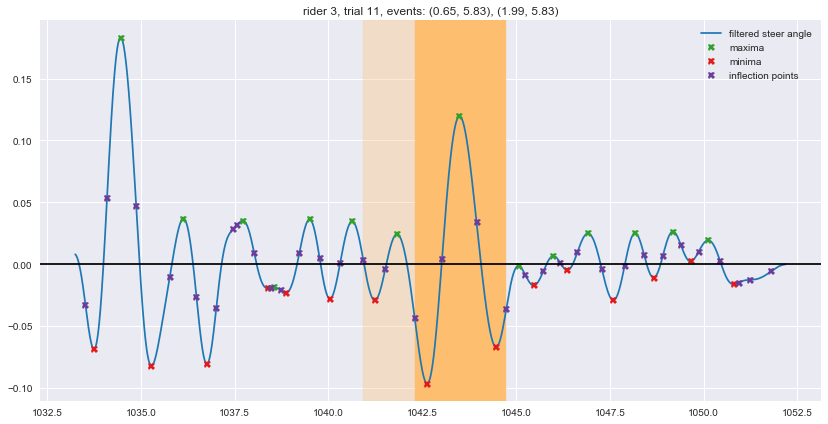

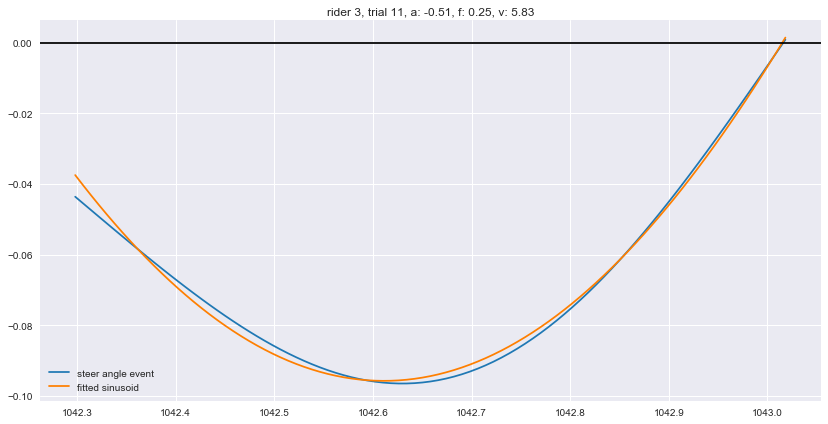

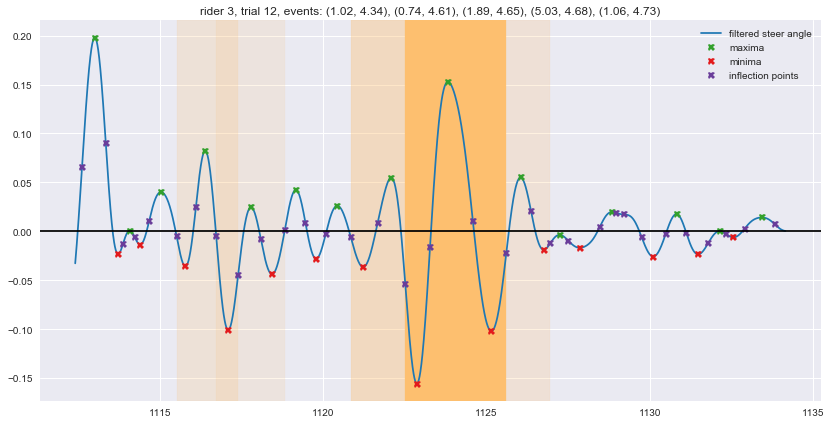

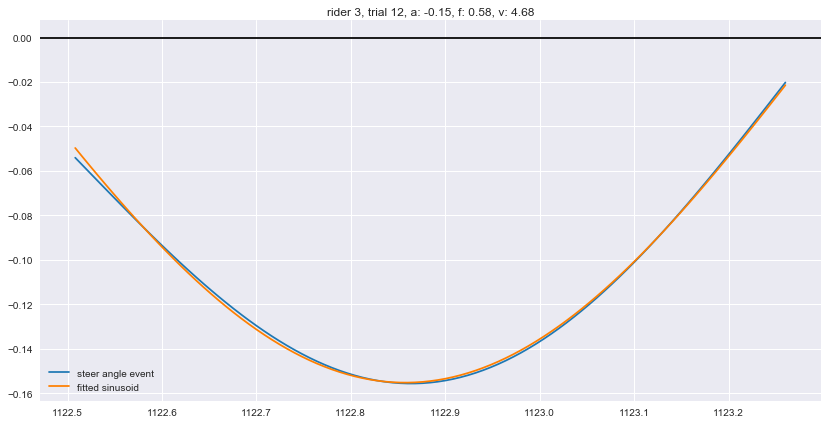

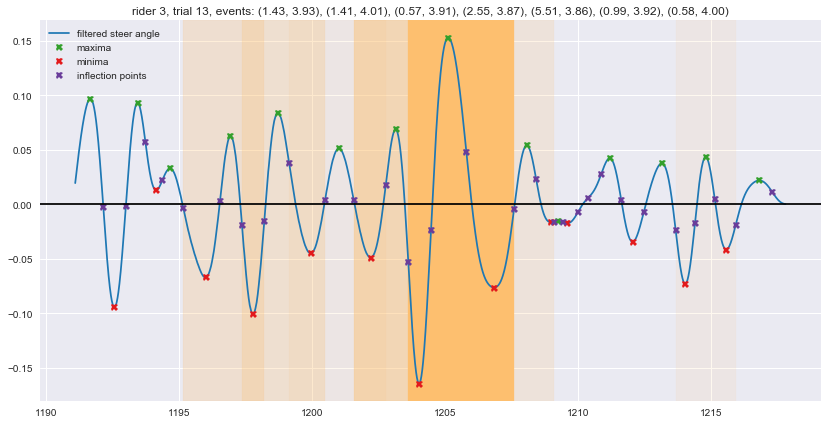

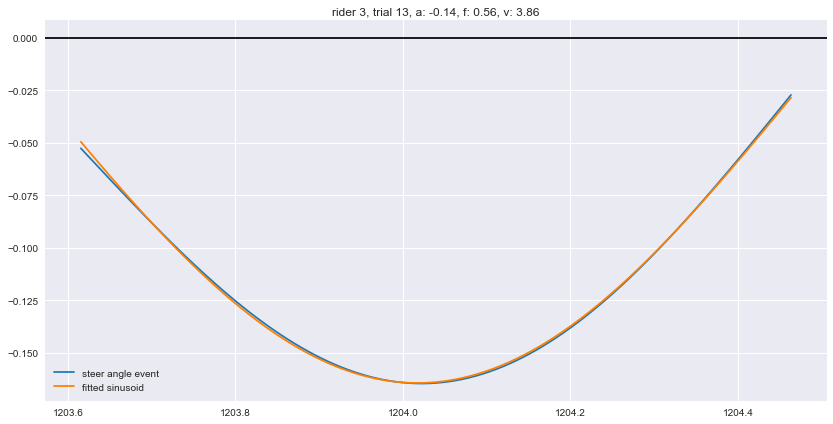

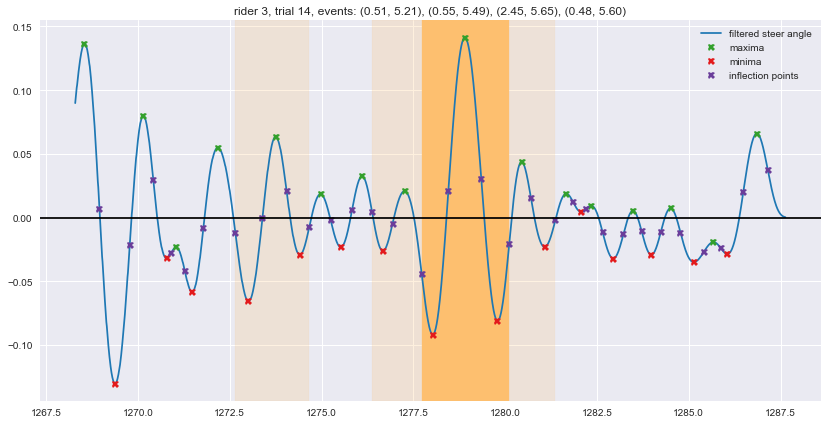

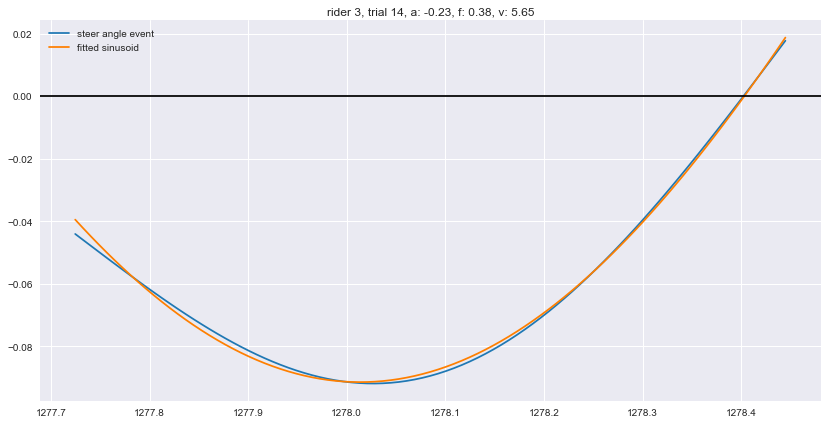

In [10]:
import numpy as np
import scipy
import seaborn as sns


# rider, speed, amplitude, freq
data = np.zeros((4*15, 5))

plt.close()
for rid, tid in itertools.product(range(4), range(15)):
    record = records[rid]
    trial = record.trial[tid]
    
    ax = trial.plot_steer_event_detection(figsize=DEFAULT_FIGSIZE)
    ax.set_title('rider {}, trial {:02d}, events: {}'.format(rid, tid, ax.get_title()))
    
    fig2, ax2 = plt.subplots(figsize=DEFAULT_FIGSIZE)
    t, y, ev = trial.steer_event_parameters()
    
    # best fit sinusoid 
    guess_ampl = -np.abs(y).max()
    guess_freq = 1/(2*(t[-1] - t[0]))
    guess_phase = -t[0]
    guess_mean = 0
    
    optimize_f = lambda x: x[0]*np.sin(2*np.pi*x[1]*(t + x[2])) + x[3] - y
    
    est = scipy.optimize.leastsq(
        optimize_f,
        [guess_ampl, guess_freq, guess_phase, guess_mean])[0]
    est_y = optimize_f(est) + y
    
    colors = sns.color_palette('Paired', 10)
    ax2.plot(t, y, label='steer angle event', color=colors[1])
    ax2.plot(t, est_y, label='fitted sinusoid', color=colors[7])
    
    fit_desc = 'rider {}, trial {:02d}, a: {:0.02f}, f: {:0.02f}, v: {:0.02f}'.format(
        rid, tid, est[0], est[1], ev.speed)
    
    data[rid*15 + tid, :] = np.array([rid, tid, ev.speed, -est[0], 1/est[1]])
    
    ax2.legend()
    ax2.set_title(fit_desc)
    ax2.axhline(0, color='black')
plt.show()

In [11]:
import pandas as pd
df = pd.DataFrame(data=data, columns=['rider', 'trial', 'v', 'a', 't'])
print(df[2:])

    rider  trial         v         a          t
2     0.0    2.0  6.022226  0.024990   2.079116
3     0.0    3.0  4.016655  0.534899   3.492856
4     0.0    4.0  5.368322  0.038307   1.523387
5     0.0    5.0  5.994924  1.362710   9.305161
6     0.0    6.0  4.567633  2.250604  10.582073
7     0.0    7.0  5.189857  1.553880   9.161846
8     0.0    8.0  6.206539  0.584989  10.814714
9     0.0    9.0  4.198477  0.215409   6.194445
10    0.0   10.0  5.559790  1.827895  11.589790
11    0.0   11.0  6.314231  0.087470   1.824191
12    0.0   12.0  4.550632  0.222515   2.574741
13    0.0   13.0  5.537313  2.025175  14.087261
14    0.0   14.0  6.351615  1.972289  26.933502
15    1.0    0.0  4.986281  0.041481   2.421580
16    1.0    1.0  6.477340  0.026489   1.647223
17    1.0    2.0  5.304934  0.166526   3.321516
18    1.0    3.0  4.390369  0.091368   3.360120
19    1.0    4.0  6.106657  2.558927  35.896533
20    1.0    5.0  5.739989  0.102116   3.327779
21    1.0    6.0  4.175392  0.095814   2

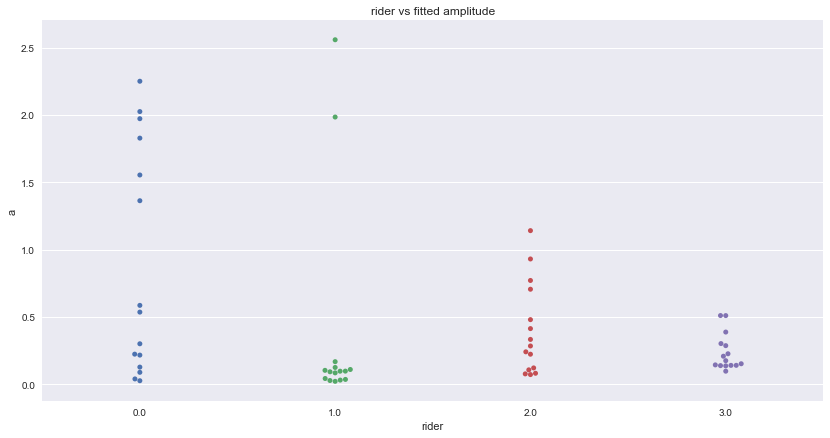

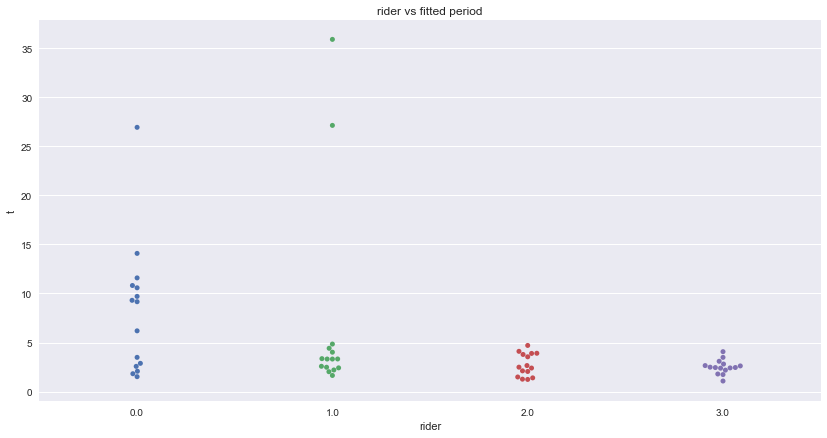

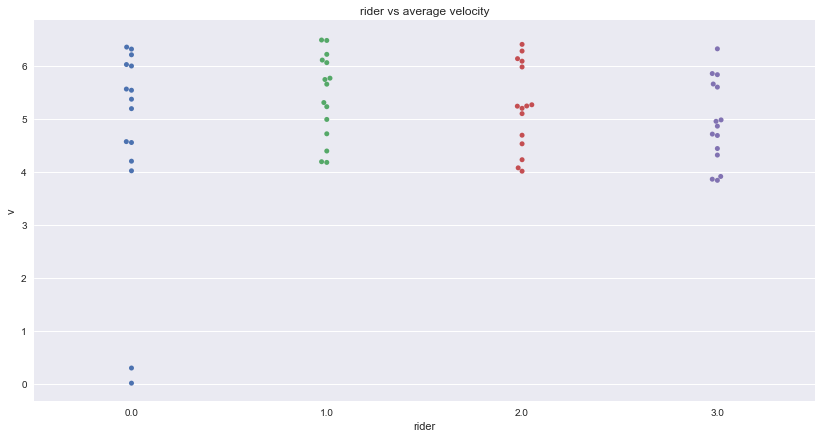

In [12]:
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
sns.swarmplot(x='rider', y='a', data=df, ax=ax)
ax.set_title('rider vs fitted amplitude')

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
sns.swarmplot(x='rider', y='t', data=df, ax=ax)
ax.set_title('rider vs fitted period')

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
sns.swarmplot(x='rider', y='v', data=df, ax=ax)
ax.set_title('rider vs average velocity')
plt.show()

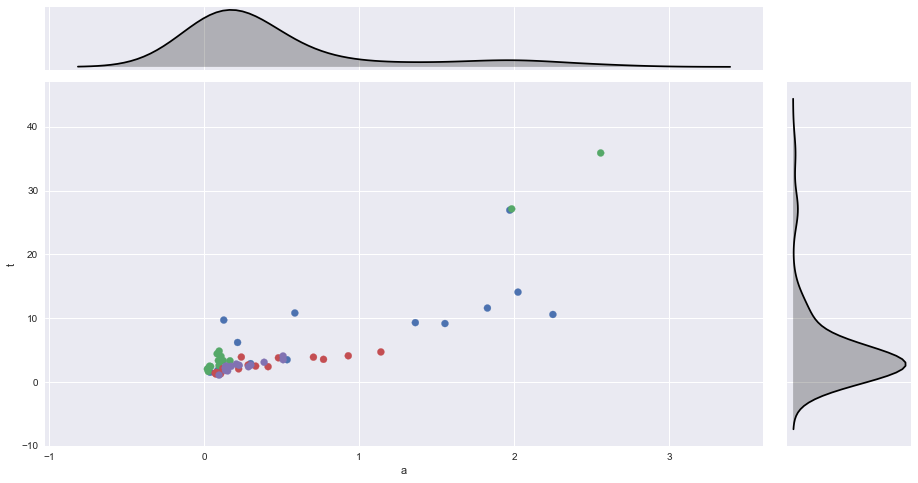

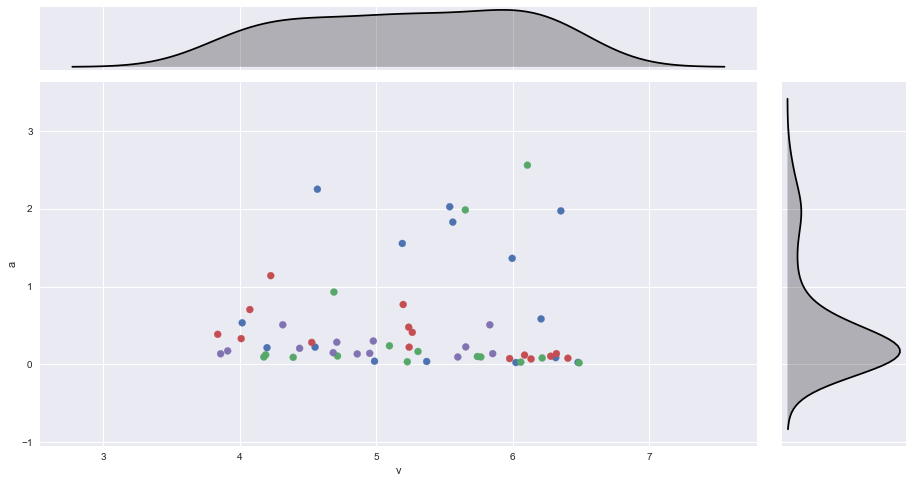

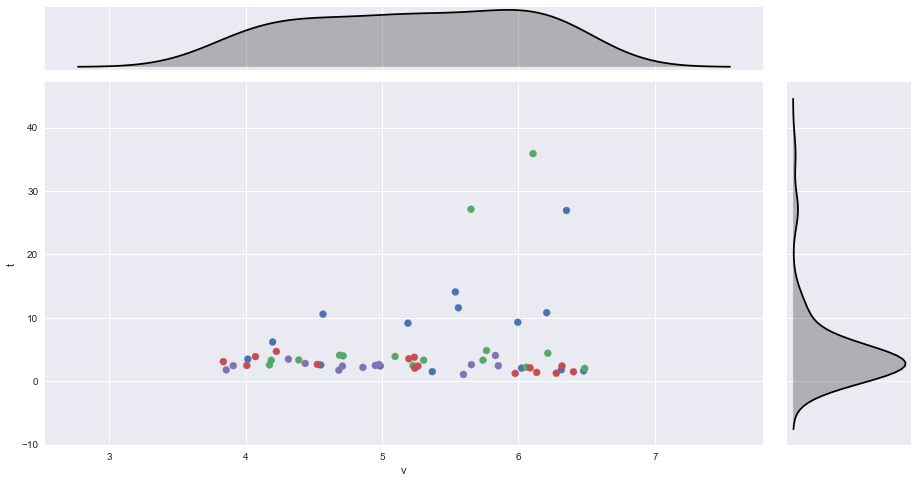

In [13]:
colors = sns.color_palette()
x = np.vectorize(lambda x: colors[int(x)])(df.as_matrix(['rider']))
colors = np.array(x).transpose().reshape((-1, 3))

def plot_joint(x, y, data):
    g = sns.JointGrid(x=x, y=y, data=data)
    g.plot_marginals(sns.kdeplot, color='black', shade=True)
    g.plot_joint(plt.scatter, color=colors)
    g.fig.set_size_inches(DEFAULT_FIGSIZE)

plt.close()
g = plot_joint('a', 't', df)
g = plot_joint('v', 'a', df[df.v > 1])
g = plot_joint('v', 't', df[df.v > 1])
plt.show()

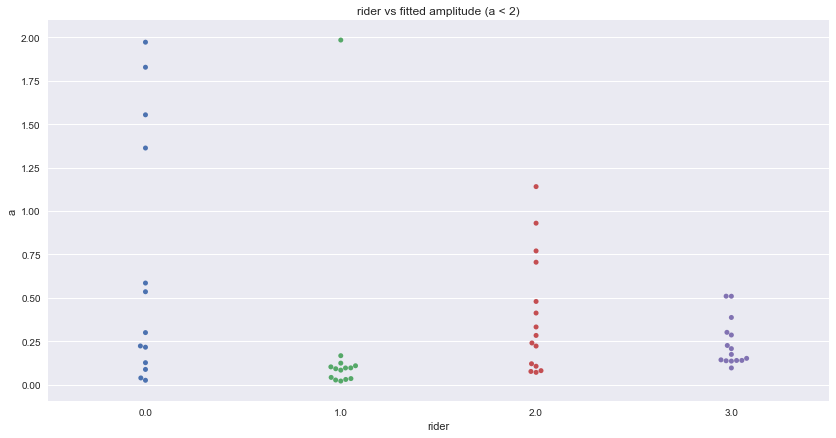

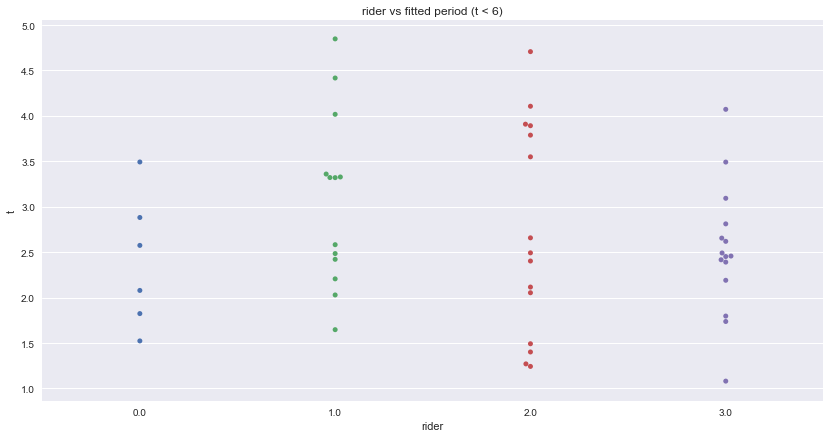

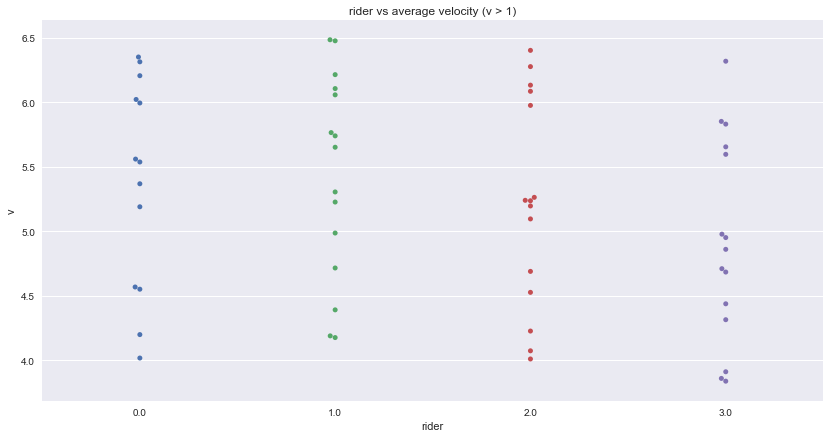

In [15]:
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
sns.swarmplot(x='rider', y='a', data=df[df.a < 2], ax=ax)
ax.set_title('rider vs fitted amplitude (a < 2)')

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
sns.swarmplot(x='rider', y='t', data=df[df.t < 6], ax=ax)
ax.set_title('rider vs fitted period (t < 6)')

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
sns.swarmplot(x='rider', y='v', data=df[df.v > 1], ax=ax)
ax.set_title('rider vs average velocity (v > 1)')
plt.show()

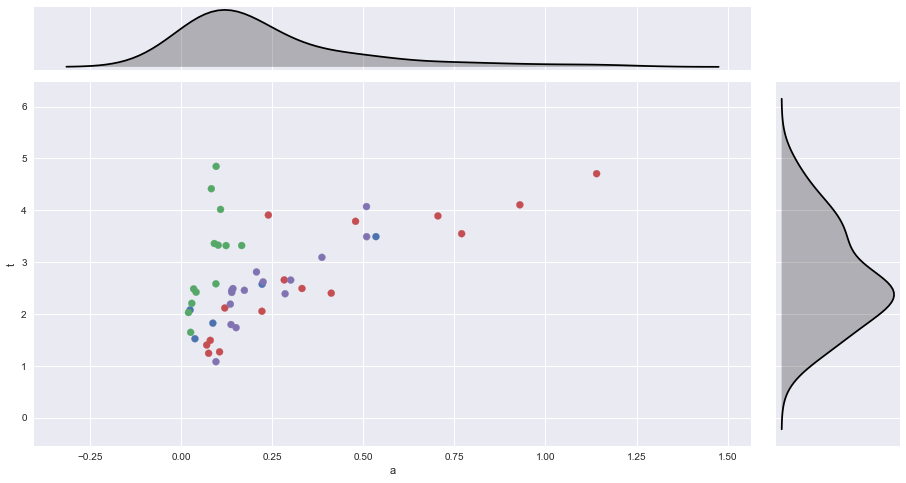

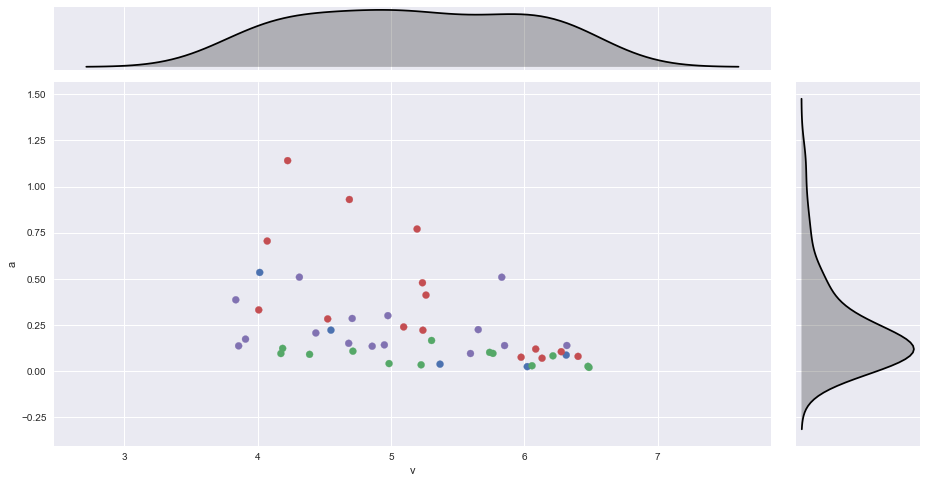

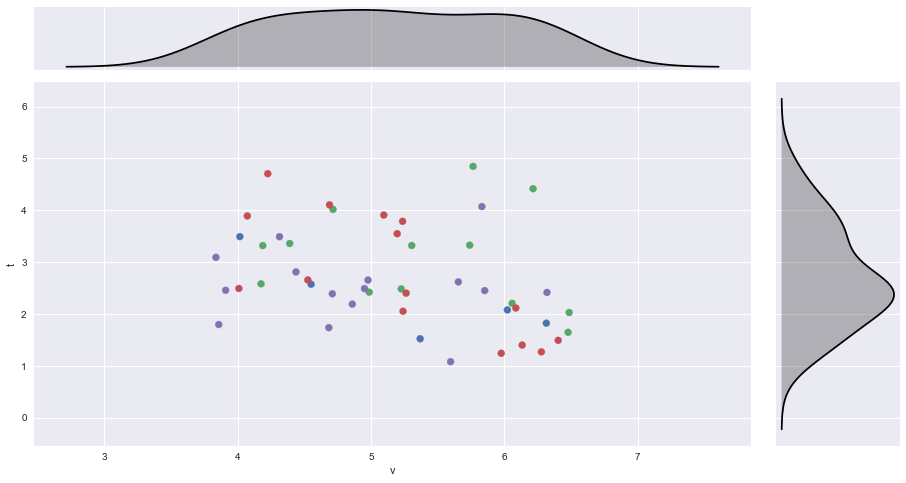

In [17]:
colors = sns.color_palette()
def color_map(df):
    x = np.vectorize(lambda x: colors[int(x)])(df.as_matrix(['rider']))
    return np.array(x).transpose().reshape((-1, 3))

def plot_joint(x, y, data):
    g = sns.JointGrid(x=x, y=y, data=data)
    g.plot_marginals(sns.kdeplot, color='black', shade=True)
    g.plot_joint(plt.scatter, color=color_map(data))
    g.fig.set_size_inches(DEFAULT_FIGSIZE)

plt.close()
g = plot_joint('a', 't', df[(df.t < 6) & (df.v > 1)])
g = plot_joint('v', 'a', df[(df.t < 6) & (df.v > 1)])
g = plot_joint('v', 't', df[(df.t < 6) & (df.v > 1)])
plt.show()